# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [127]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
#% matplotlib inline

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, log_loss, f1_score
from sklearn.utils import resample
from sklearn.decomposition import PCA
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
import pickle


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [6]:
print(portfolio.shape)
print(profile.shape)
print(transcript.shape)

(10, 6)
(17000, 5)
(306534, 4)


In [7]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [8]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [9]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


# Data cleaning

### Profile

## Data type

In [4]:
def convert_data_type(df, int_var_list=None, float_var_list=None, str_var_list=None):
    '''
    DESCRIPTION:
    Ensure data types are consistent. Convert values in dataframe 
    into desired data types.
    
    INPUTS:
    df - The dataframe that we want to work with
    int_var_list - The list of variable to be converted to integers
    float_var_list - The list of variables to be converted to floats
    str_var_list - The list of variables to be converted to strings
    
    OUTPUTS:
    df - The dataframe that with the variables converted to the desired types
    '''

    if int_var_list != None:
        for int_var in int_var_list:
            df[int_var] = df[int_var].apply(lambda x: int(x))
        
    if float_var_list != None:
        for float_var in float_var_list:
            df[float_var] = df[float_var].apply(lambda x: float(x))
        

    if str_var_list != None:
        for str_var in str_var_list:
            df[str_var] = df[str_var].apply(lambda x: str(x))
        
    return df

In [5]:
# ensure age is int
# ensure gender is string
# ensure income is float
int_var_list = ['age']
float_var_list = ['income']
str_var_list = ['gender']
profile = convert_data_type(profile, int_var_list, float_var_list, str_var_list)

## Missing values

In [6]:
# replace missing values by nan values
profile["age"] = profile["age"].replace(118,np.nan)
profile["gender"] = profile["gender"].replace("None",np.nan)
profile["income"] = profile["income"].replace("NaN",np.nan)

In [6]:
profile["age"].describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

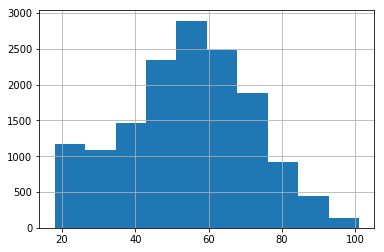

In [77]:
# Distribution of age
profile["age"].hist()

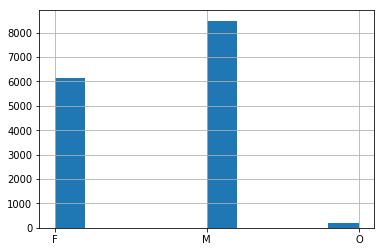

In [78]:
# Distribution of gender
profile["gender"].hist()

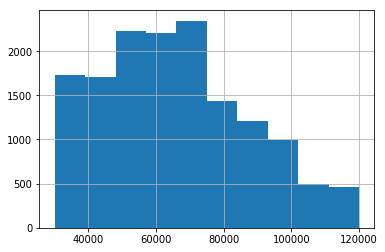

In [79]:
# Distribution of income
profile["income"].hist()

In [7]:
# is there a lot of missing values? 
profile.isnull().mean()

age                 0.127941
became_member_on    0.000000
gender              0.127941
id                  0.000000
income              0.127941
dtype: float64

In [7]:
profile[profile['gender'].isnull() & profile['age'].isnull() & profile['income'].isnull()].head()

,gender,age,id,became_member_on,income
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,NaN,NaN,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,NaN,NaN,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [8]:
len(profile[profile['gender'].isnull() & profile['age'].isnull() & profile['income'].isnull()])/len(profile)

0.12794117647058822

We can notice that when there is a missing value for age, income or gender, there are missing values for the other two
We have two possibilities: remove those rows that represent 13% of the base, or estimate the missing values 
We are going to try to estimate these values. So, we have to create new variables

In [9]:
# convert became_member_on to datetime
# and extract year, month, day
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['member_year'] = profile['became_member_on'].dt.year
profile['member_month'] = profile['became_member_on'].dt.month
profile['member_day'] = profile['became_member_on'].dt.day
profile.drop(['became_member_on'], axis=1, inplace=True)

### Portfolio

In [84]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [10]:
def encode_channel(portfolio_df):
    '''
    DESCRIPTION:
    Extract and perform one-hot encodings for the available channels in portfolio
    
    INPUTS:
    portfolio_df - The portfolio dataframe
    
    OUTPUTS:
    portfolio_df - The portfolio dataframe with the one-hot encoded channels
    '''
    # find all available channels
    available_channels = []
    for channel_list in portfolio_df['channels']:
        for channel in channel_list:
            if channel not in available_channels:
                available_channels.append(channel)
    
    # one-hot encode channel
    for channel in available_channels:
        portfolio_df[channel] = portfolio_df['channels'].apply(lambda x: 1 if channel in x else 0)
    
    # drop channels column
    portfolio_df.drop(['channels'], axis=1, inplace=True)
    
    return portfolio_df

In [11]:
portfolio_df = encode_channel(portfolio)

In [12]:
portfolio_df.head()

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


### Transcript

In [91]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


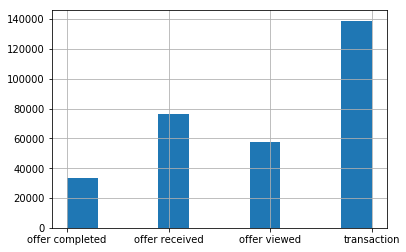

In [90]:
transcript["event"].hist()

In [13]:
# Functions to create offer id and amount columns from the transcript table.
def create_offer_id_column(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]
    
def create_amount_column(val):
    if list(val.keys())[0] in ["amount"]:
        return list(val.values())[0]

In [14]:
transcript['offer_id'] = transcript.value.apply(create_offer_id_column)
transcript['amount'] = transcript.value.apply(create_amount_column)

In [18]:
transcript.head()

,event,person,time,value,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [15]:
profile.rename(index=str, columns={"id":"client_id"}, inplace=True)
portfolio.rename(index=str, columns={"id":"offer_id"}, inplace=True)
transcript.rename(index=str, columns={"person":"client_id"}, inplace=True)

## Merge profile, transcript and portfolio

In [16]:
# merge transcript_offer with profile
transcript_profile = pd.merge(transcript, profile, how='left', on='client_id')

# merge transcript_offer with portfolio
offer_global = pd.merge(transcript_profile, portfolio, how='left', on='offer_id')

In [36]:
offer_global.head()

,event,client_id,time,value,offer_id,amount,age,gender,income,member_year,member_month,member_day,difficulty,duration,offer_type,reward,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,F,100000.0,2017,5,9,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,2017,8,4,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,68.0,M,70000.0,2018,4,26,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaN,2017,9,25,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaN,2017,10,2,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [17]:
offer_global.shape

(306534, 20)

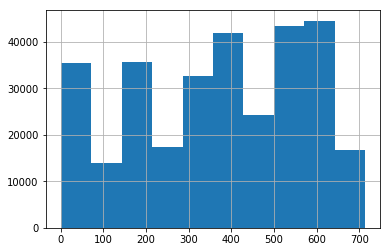

In [38]:
offer_global.time.hist()

In [17]:
# Base of offer received
offer_received = offer_global[offer_global["event"] == "offer received"]

In [16]:
offer_received.shape

(76277, 20)

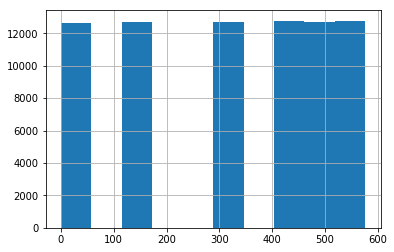

In [46]:
offer_received.time.hist()

In [18]:
# changing column name 
offer_received.rename(index=str, columns={"time":"time received"}, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [19]:
# Base of offer viewed
offer_viewed = offer_global[offer_global["event"] == "offer viewed"]

In [42]:
offer_viewed.shape

(57725, 20)

In [43]:
offer_viewed.head()

,event,client_id,time,value,offer_id,amount,age,gender,income,member_year,member_month,member_day,difficulty,duration,offer_type,reward,email,mobile,social,web
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN,65.0,M,53000.0,2018,2,9,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,NaN,53.0,O,52000.0,2017,9,16,0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,69.0,F,57000.0,2016,8,14,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd,NaN,20.0,F,30000.0,2016,7,11,10.0,7.0,bogo,10.0,1.0,1.0,1.0,0.0
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,NaN,39.0,M,51000.0,2014,5,27,0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0


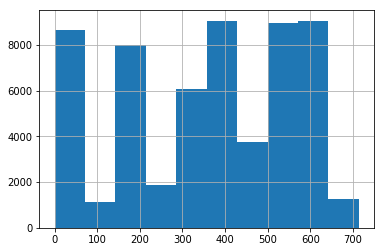

In [44]:
offer_viewed.time.hist()

In [20]:
offer_viewed.rename(index=str, columns={"time":"time viewed"}, inplace=True)

In [21]:
# Base of offer completed
offer_completed = offer_global[offer_global["event"] == "offer completed"]

In [50]:
offer_completed.shape

(33579, 20)

In [51]:
offer_completed.head()

,event,client_id,time,value,offer_id,amount,age,gender,income,member_year,member_month,member_day,difficulty,duration,offer_type,reward,email,mobile,social,web
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,2906b810c7d4411798c6938adc9daaa5,NaN,42.0,M,96000.0,2016,1,17,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,NaN,39.0,F,67000.0,2017,12,17,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,52.0,M,72000.0,2018,6,5,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd,NaN,37.0,M,92000.0,2017,5,15,10.0,7.0,bogo,10.0,1.0,1.0,1.0,0.0
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,48.0,M,62000.0,2015,9,3,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


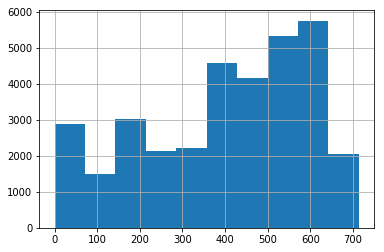

In [52]:
offer_completed.time.hist()

In [22]:
offer_completed.rename(index=str, columns={"time":"time completed"}, inplace=True)

In [23]:
# dropping columns in order to merge
cols_to_drop = ['event', 'age', 'gender', 'income', 'member_year', 'member_month',\
                'member_day', 'difficulty', 'duration', 'offer_type', 'reward',\
                'email', 'mobile', 'social', 'web', 'value', 'amount']
offer_viewed.drop(cols_to_drop, axis=1, inplace=True)
offer_completed.drop(cols_to_drop, axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [400]:
# merge all 3 together
offers = pd.merge(offer_received, offer_viewed, on=['client_id', 'offer_id'], how='left')
offers = pd.merge(offers, offer_completed, on=['client_id', 'offer_id'], how='left')
offers.head()

,client_id,event,value,time received,offer_id,amount,gender,age,income,member_year,...,reward,difficulty,duration,offer_type,email,mobile,social,web,time viewed,time completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,100000.0,2017,...,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,6.0,132.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,2017,...,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,6.0,NaN
2,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,2017,...,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,624.0,NaN
3,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,M,68.0,70000.0,2018,...,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,18.0,NaN
4,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaN,2017,...,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,12.0,NaN


We're going to calculate whether the offers are corrects (with comparaison between duration and time) 

In [401]:
# add time of offer expiry column. This will track when offers expires
# we multiply the duration because it's in days, and the variable "time" is in hours
offers['time_expiry'] =  offers['time received'] + (offers['duration'] * 24)

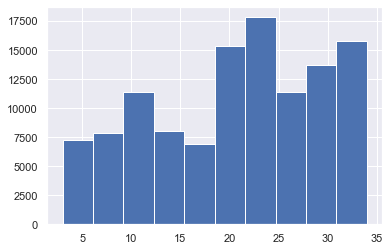

In [402]:
# time_expiry in days
(offers['time_expiry']/24).hist()

We have to found out if all the offers are corrects i.e. if time received < time viewed and time completed < time viewed

In [403]:
offers = offers[((offers['time viewed'] >= offers['time received']) & (offers['time completed'] >= offers['time viewed']))
                        |
                        # offers that are viewed after they are received but not completed
                        ((offers['time viewed'] >= offers['time received']) & offers['time completed'].isnull())
                        |
                        # offers that are received but not viewed or completed
                        (offers['time viewed'].isnull() & offers['time completed'].isnull())
                       ]

In [404]:
offers.shape

(77802, 23)

In [405]:
offers.drop("value",axis=1, inplace=True)

We have to find out if offers have been successful, not yet successful, or failed 

In [29]:
# When an offer is successful, it means that time received is lower than time viewed which is lower than time completed which is lower than time expiry
# However if time completed is not completed yet or is greater than time expiry, it means the customer has tried to use the offer

def probable_successful_offers(df):
    if ((df['time received'] <= df['time viewed']) &\
        (df['time viewed'] <= df['time completed']) &\
        (df['time completed'] <= df['time_expiry'])):
        return 1
    else:
        return 0
    
def probable_tried_offers(df):
    if (((df['time received'] <= df['time viewed']) &\
         (df['time viewed'] <= df['time_expiry']) &\
         (df['time_expiry'] < df['time completed']))
        |\
        ((df['time received'] <= df['time viewed']) &\
         (df['time viewed'] <= df['time_expiry']) &\
         (math.isnan(df['time completed'])))):
        return 1
    else:
        return 0
    
def probable_failed_offers(df):
    if ((df['successful offer'] == 1) | (df['tried offer'] == 1)):
        return 0
    else:
        return 1

offers['successful offer'] = offers.apply(probable_successful_offers, axis=1)
offers['tried offer'] = offers.apply(probable_tried_offers, axis=1)
offers['failed offer'] = offers.apply(probable_failed_offers, axis=1)

In [30]:
offers[offers['successful offer']==1].head(10)

,client_id,event,time received,offer_id,amount,gender,age,income,member_year,member_month,...,email,mobile,social,web,time viewed,time completed,time_expiry,successful offer,tried offer,failed offer
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,100000.0,2017,5,...,1.0,1.0,0.0,1.0,6.0,132.0,168.0,1,0,0
7,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,M,65.0,53000.0,2018,2,...,1.0,1.0,1.0,1.0,0.0,60.0,120.0,1,0,0
22,d53717f5400c4e84affdaeda9dd926b3,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,F,88.0,53000.0,2017,5,...,1.0,0.0,0.0,1.0,30.0,30.0,240.0,1,0,0
26,f806632c011441378d4646567f357a21,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,M,42.0,69000.0,2013,8,...,1.0,1.0,1.0,1.0,18.0,126.0,240.0,1,0,0
30,d058f73bf8674a26a95227db098147b1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,F,56.0,88000.0,2018,4,...,1.0,0.0,0.0,1.0,30.0,192.0,240.0,1,0,0
39,102e9454054946fda62242d2e176fdce,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,F,69.0,57000.0,2016,8,...,1.0,1.0,1.0,1.0,0.0,6.0,120.0,1,0,0
41,9f30b375d7bd4c62a884ffe7034e09ee,offer received,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,F,26.0,63000.0,2017,8,...,1.0,1.0,1.0,1.0,42.0,114.0,168.0,1,0,0
43,6e014185620b49bd98749f728747572f,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,M,75.0,40000.0,2015,11,...,1.0,1.0,1.0,1.0,66.0,66.0,120.0,1,0,0
45,c0d210398dee4a0895b24444a5fcd1d2,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,45.0,33000.0,2018,7,...,1.0,1.0,0.0,1.0,30.0,66.0,168.0,1,0,0
46,8be4463721e14d7fa600686bf8c8b2ed,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaN,2017,5,...,1.0,1.0,1.0,1.0,24.0,96.0,240.0,1,0,0


In [31]:
offers[offers['tried offer']==1].head(10)

,client_id,event,time received,offer_id,amount,gender,age,income,member_year,member_month,...,email,mobile,social,web,time viewed,time completed,time_expiry,successful offer,tried offer,failed offer
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,2017,8,...,1.0,0.0,0.0,1.0,6.0,NaN,240.0,0,1,0
3,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,M,68.0,70000.0,2018,4,...,1.0,1.0,0.0,1.0,18.0,NaN,168.0,0,1,0
4,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaN,2017,9,...,1.0,1.0,1.0,1.0,12.0,NaN,240.0,0,1,0
6,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaN,2017,10,...,1.0,1.0,1.0,1.0,84.0,NaN,120.0,0,1,0
8,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,M,65.0,53000.0,2018,2,...,1.0,1.0,1.0,1.0,0.0,600.0,120.0,0,1,0
11,c4863c7985cf408faee930f111475da3,offer received,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,NaN,2017,8,...,1.0,1.0,1.0,1.0,24.0,NaN,168.0,0,1,0
14,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,F,61.0,57000.0,2017,9,...,1.0,0.0,0.0,1.0,18.0,NaN,240.0,0,1,0
15,31dda685af34476cad5bc968bdb01c53,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,F,62.0,71000.0,2016,2,...,1.0,0.0,0.0,1.0,150.0,NaN,240.0,0,1,0
16,744d603ef08c4f33af5a61c8c7628d1c,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,2017,8,...,1.0,0.0,0.0,1.0,48.0,NaN,240.0,0,1,0
17,3d02345581554e81b7b289ab5e288078,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,2017,1,...,1.0,0.0,0.0,1.0,24.0,NaN,240.0,0,1,0


In [32]:
offers[offers['failed offer']==1]

,client_id,event,time received,offer_id,amount,gender,age,income,member_year,member_month,...,email,mobile,social,web,time viewed,time completed,time_expiry,successful offer,tried offer,failed offer
2,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,2017,8,...,1.0,0.0,0.0,1.0,624.0,NaN,240.0,0,0,1
5,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaN,2017,9,...,1.0,1.0,1.0,1.0,522.0,NaN,240.0,0,0,1
10,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,M,65.0,53000.0,2018,2,...,1.0,1.0,1.0,1.0,504.0,600.0,120.0,0,0,1
12,c4863c7985cf408faee930f111475da3,offer received,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,NaN,2017,8,...,1.0,1.0,1.0,1.0,348.0,NaN,168.0,0,0,1
13,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,M,58.0,51000.0,2017,11,...,1.0,1.0,0.0,1.0,NaN,NaN,96.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115584,54bead4179c44b71acc4e8398181d183,offer received,576,2906b810c7d4411798c6938adc9daaa5,NaN,F,29.0,58000.0,2017,2,...,1.0,1.0,0.0,1.0,NaN,NaN,744.0,0,0,1
115589,ff737c250d2343729ade04c4f6eb1001,offer received,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,F,72.0,65000.0,2015,4,...,1.0,0.0,0.0,1.0,NaN,NaN,816.0,0,0,1
115594,97ee6e7a12fe4064b260fa48bdd0330f,offer received,576,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,26.0,55000.0,2018,6,...,1.0,1.0,0.0,1.0,NaN,NaN,744.0,0,0,1
115595,bf3069b178fe40d789dd027901bc406b,offer received,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,F,59.0,63000.0,2017,7,...,1.0,0.0,0.0,1.0,NaN,NaN,816.0,0,0,1


In [134]:
offers.shape

(77802, 25)

In [33]:
# we test our dataset to make out if there are data duplicated 
offers[offers.duplicated(subset=['time received', 'client_id', 'offer_id'])][['client_id', 'offer_id', 'time received', 'time viewed', 'time completed', 'time_expiry', 'successful offer', 'tried offer', 'failed offer']].head()

,client_id,offer_id,time received,time viewed,time completed,time_expiry,successful offer,tried offer,failed offer
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,624.0,NaN,240.0,0,0,1
5,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,522.0,NaN,240.0,0,0,1
8,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0,0.0,600.0,120.0,0,1,0
10,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0,504.0,600.0,120.0,0,0,1
12,c4863c7985cf408faee930f111475da3,2298d6c36e964ae4a3e7e9706d1fb8c2,0,348.0,NaN,168.0,0,0,1


In [34]:
# drop all rows with duplicated client_id, offer_id and time_received
# very likely they are doible counting
offers.drop_duplicates(subset=['time received', 'client_id', 'offer_id'], keep='first', inplace=True)

In [31]:
offers.shape

(65109, 25)

In [110]:
transcript.head()

,event,client_id,time,value,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [35]:
# determine whether row deals with offer or transcation
transcript['value_type'] = transcript['value'].apply(lambda x : list(x.keys())[0])

In [36]:
# get transcript for transactions only
transcript_trans = transcript[transcript['value_type']=='amount']
transcript_trans.drop(['event', 'value', 'value_type','offer_id'], axis=1, inplace=True)
transcript_trans.rename(index=str, columns={"time":"time_spent", "amount":"amt_spent"}, inplace=True)
transcript_trans.head()

,client_id,time_spent,amt_spent
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [37]:
# find all possible cross product successful/tried offers and transactions
offers_trans = pd.merge(offers, transcript_trans, on='client_id', how='left')
offers_trans.head()

,client_id,event,time received,offer_id,amount,gender,age,income,member_year,member_month,...,social,web,time viewed,time completed,time_expiry,successful offer,tried offer,failed offer,time_spent,amt_spent
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,100000.0,2017,5,...,0.0,1.0,6.0,132.0,168.0,1,0,0,132.0,19.89
1,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,100000.0,2017,5,...,0.0,1.0,6.0,132.0,168.0,1,0,0,144.0,17.78
2,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,100000.0,2017,5,...,0.0,1.0,6.0,132.0,168.0,1,0,0,222.0,19.67
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,100000.0,2017,5,...,0.0,1.0,6.0,132.0,168.0,1,0,0,240.0,29.72
4,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,100000.0,2017,5,...,0.0,1.0,6.0,132.0,168.0,1,0,0,378.0,23.93


In [123]:
offers_trans[offers_trans['failed offer']==1]

,event,client_id,time received,offer_id,amount,age,gender,income,member_year,member_month,...,social,web,time viewed,time completed,time_expiry,successful offer,tried offer,failed offer,time_spent,amt_spent
10,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,2017,8,...,0.0,1.0,624.0,NaN,240.0,0,0,1,234.0,1.09
11,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,2017,8,...,0.0,1.0,624.0,NaN,240.0,0,0,1,264.0,3.50
12,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,2017,8,...,0.0,1.0,624.0,NaN,240.0,0,0,1,612.0,0.06
17,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaN,2017,9,...,1.0,1.0,522.0,NaN,240.0,0,0,1,NaN,NaN
26,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,65.0,M,53000.0,2018,2,...,1.0,1.0,504.0,600.0,120.0,0,0,1,60.0,9.54
27,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,65.0,M,53000.0,2018,2,...,1.0,1.0,504.0,600.0,120.0,0,0,1,498.0,15.63
28,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,65.0,M,53000.0,2018,2,...,1.0,1.0,504.0,600.0,120.0,0,0,1,600.0,11.26
38,offer received,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,NaN,2017,8,...,1.0,1.0,348.0,NaN,168.0,0,0,1,66.0,0.89
39,offer received,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,NaN,2017,8,...,1.0,1.0,348.0,NaN,168.0,0,0,1,354.0,3.46
40,offer received,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,NaN,2017,8,...,1.0,1.0,348.0,NaN,168.0,0,0,1,390.0,0.58


In [124]:
offers_trans[offers_trans['tried offer']==1]

,event,client_id,time received,offer_id,amount,age,gender,income,member_year,member_month,...,social,web,time viewed,time completed,time_expiry,successful offer,tried offer,failed offer,time_spent,amt_spent
7,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,2017,8,...,0.0,1.0,6.0,NaN,240.0,0,1,0,234.0,1.09
8,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,2017,8,...,0.0,1.0,6.0,NaN,240.0,0,1,0,264.0,3.50
9,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,2017,8,...,0.0,1.0,6.0,NaN,240.0,0,1,0,612.0,0.06
13,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,M,70000.0,2018,4,...,0.0,1.0,18.0,NaN,168.0,0,1,0,288.0,17.88
14,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,M,70000.0,2018,4,...,0.0,1.0,18.0,NaN,168.0,0,1,0,294.0,21.43
15,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,M,70000.0,2018,4,...,0.0,1.0,18.0,NaN,168.0,0,1,0,522.0,18.42
16,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaN,2017,9,...,1.0,1.0,12.0,NaN,240.0,0,1,0,NaN,NaN
18,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaN,2017,10,...,1.0,1.0,84.0,NaN,120.0,0,1,0,354.0,0.19
19,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaN,2017,10,...,1.0,1.0,84.0,NaN,120.0,0,1,0,654.0,0.05
23,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,65.0,M,53000.0,2018,2,...,1.0,1.0,0.0,600.0,120.0,0,1,0,60.0,9.54


In [38]:
def check_offer_transactions(df):
    """
    DESCRIPTION:
    Check if the offer is correct
    
    INPUTS:
    df - The dataframe
      
    """
    if df['successful offer'] == 1:
        if (df['time_spent'] >= df['time received']) and (df['time_spent'] <= df['time completed']):
            return 1
        else:
            return 0
    else:
        if (df['time_spent'] >= df['time received']) and (df['time_spent'] <= df['time_expiry']):
            return 1
        else:
            return 0

offers_trans['spent_during_offer'] = offers_trans.apply(check_offer_transactions, axis=1)

In [39]:
# offers that have transactions occuring during their validity period are very likely to be offers 
offers_trans = offers_trans[offers_trans['spent_during_offer']==1]

offers_trans.head()

,client_id,event,time received,offer_id,amount,gender,age,income,member_year,member_month,...,web,time viewed,time completed,time_expiry,successful offer,tried offer,failed offer,time_spent,amt_spent,spent_during_offer
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,100000.0,2017,5,...,1.0,6.0,132.0,168.0,1,0,0,132.0,19.89,1
7,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,2017,8,...,1.0,6.0,NaN,240.0,0,1,0,234.0,1.09,1
16,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,M,65.0,53000.0,2018,2,...,1.0,0.0,60.0,120.0,1,0,0,60.0,9.54,1
19,c4863c7985cf408faee930f111475da3,offer received,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,NaN,2017,8,...,1.0,24.0,NaN,168.0,0,1,0,66.0,0.89,1
32,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,F,61.0,57000.0,2017,9,...,1.0,18.0,NaN,240.0,0,1,0,210.0,12.33,1


In [40]:
# count number of offers for each individual
succ_tried_offers_unique = offers_trans.drop_duplicates(['time received', 'client_id', 'offer_id'])
succ_tried_offers_counts = succ_tried_offers_unique.groupby(['client_id', 'offer_id']).agg({'successful offer':'sum',\
                                                                                         'tried offer':'sum',\
                                                                                            'failed offer':'sum'
                                                                                        }).reset_index()

succ_tried_offers_counts.rename(index=str, columns={"successful offer":"n_succ_offers","tried offer":"n_tried_offers","failed offer":"n_failed_offers"}, inplace=True)

succ_tried_offers_counts.head(10)

,client_id,offer_id,n_succ_offers,n_tried_offers,n_failed_offers
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,0
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,0,0
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
5,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0
6,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,0,0,1
7,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1,0,0
8,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1,0,0
9,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,0,1,0


In [41]:
succ_tried_offers_counts[succ_tried_offers_counts["n_succ_offers"] > 1].head()

,client_id,offer_id,n_succ_offers,n_tried_offers,n_failed_offers
14,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,2,0,0
21,004c5799adbf42868b9cff0396190900,f19421c1d4aa40978ebb69ca19b0e20d,2,0,0
48,0091d2b6a5ea4defaa8393e4e816db60,f19421c1d4aa40978ebb69ca19b0e20d,2,0,0
66,00ae03011f9f49b8a4b3e6d416678b0b,2298d6c36e964ae4a3e7e9706d1fb8c2,2,0,0
69,00b18b535d6d4f779dea4dc9ac451478,2298d6c36e964ae4a3e7e9706d1fb8c2,2,0,0


In [42]:
# tracks how much money was spent during period of time when offer is active
succ_tried_offers_summary = offers_trans.groupby(['client_id', 'offer_id']).agg({'amt_spent': 'sum',\
                                                       'spent_during_offer': 'count'}).reset_index()

succ_tried_offers_summary.rename(index=str,\
                               columns={"amt_spent":"total_offer_spent",\
                                        "spent_during_offer": "total_num_offer_trans"}, inplace=True)

succ_tried_offers_summary['avg_spent_offer_trans'] = succ_tried_offers_summary['total_offer_spent']/(succ_tried_offers_summary['total_num_offer_trans']*1.0)

succ_tried_offers_summary.head()

,client_id,offer_id,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,8.57,1,8.57
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,22.16,1,22.16
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,22.05,1,22.05
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11.93,1,11.93
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05,1,22.05


In [43]:
succ_tried_offers_summary[succ_tried_offers_summary["total_num_offer_trans"] > 1].head(10)

,client_id,offer_id,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans
6,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,51.10,2,25.550000
9,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,58.87,4,14.717500
12,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,12.27,4,3.067500
13,003d66b6608740288d6cc97a6903f4f0,5a8bc65990b245e5a138643cd4eb9837,2.51,2,1.255000
14,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,23.95,10,2.395000
15,00426fe3ffde4c6b9cb9ad6d077a13ea,0b1e1539f2cc45b7b9fa7c272da2e1d7,6.62,3,2.206667
16,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,7.84,4,1.960000
17,00426fe3ffde4c6b9cb9ad6d077a13ea,5a8bc65990b245e5a138643cd4eb9837,25.92,5,5.184000
18,00426fe3ffde4c6b9cb9ad6d077a13ea,fafdcd668e3743c1bb461111dcafc2a4,23.34,3,7.780000
21,004c5799adbf42868b9cff0396190900,f19421c1d4aa40978ebb69ca19b0e20d,58.73,2,29.365000


In [44]:
offers_summary = pd.merge(succ_tried_offers_summary, succ_tried_offers_counts,\
                                     on=['client_id', 'offer_id'], how='left', validate='one_to_one')

offers_summary.head(15)

,client_id,offer_id,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers,n_failed_offers
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,8.57,1,8.5700,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,22.16,1,22.1600,0,1,0
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,22.05,1,22.0500,1,0,0
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11.93,1,11.9300,1,0,0
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05,1,22.0500,1,0,0
5,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,17.24,1,17.2400,1,0,0
6,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,51.10,2,25.5500,0,0,1
7,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,17.63,1,17.6300,1,0,0
8,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,11.65,1,11.6500,1,0,0
9,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,58.87,4,14.7175,0,1,0


In [45]:
offers_summary.isnull().mean()

client_id                0.0
offer_id                 0.0
total_offer_spent        0.0
total_num_offer_trans    0.0
avg_spent_offer_trans    0.0
n_succ_offers            0.0
n_tried_offers           0.0
n_failed_offers          0.0
dtype: float64

### Offer type

In [43]:
portfolio["offer_id"].unique

<bound method Series.unique of 0    ae264e3637204a6fb9bb56bc8210ddfd
1    4d5c57ea9a6940dd891ad53e9dbe8da0
2    3f207df678b143eea3cee63160fa8bed
3    9b98b8c7a33c4b65b9aebfe6a799e6d9
4    0b1e1539f2cc45b7b9fa7c272da2e1d7
5    2298d6c36e964ae4a3e7e9706d1fb8c2
6    fafdcd668e3743c1bb461111dcafc2a4
7    5a8bc65990b245e5a138643cd4eb9837
8    f19421c1d4aa40978ebb69ca19b0e20d
9    2906b810c7d4411798c6938adc9daaa5
Name: offer_id, dtype: object>

In [46]:
portfolio[["offer_id","offer_type"]].groupby(["offer_id","offer_type"]).count()

,
offer_id,offer_type
0b1e1539f2cc45b7b9fa7c272da2e1d7,discount
2298d6c36e964ae4a3e7e9706d1fb8c2,discount
2906b810c7d4411798c6938adc9daaa5,discount
3f207df678b143eea3cee63160fa8bed,informational
4d5c57ea9a6940dd891ad53e9dbe8da0,bogo
5a8bc65990b245e5a138643cd4eb9837,informational
9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
ae264e3637204a6fb9bb56bc8210ddfd,bogo
f19421c1d4aa40978ebb69ca19b0e20d,bogo


In [47]:
name_offer = {
    "0b1e1539f2cc45b7b9fa7c272da2e1d7" : "discount_1",
    "2298d6c36e964ae4a3e7e9706d1fb8c2" : "discount_2",
    "2906b810c7d4411798c6938adc9daaa5" : "discount_3",
    "3f207df678b143eea3cee63160fa8bed" : "informational_1",
    "4d5c57ea9a6940dd891ad53e9dbe8da0" : "bogo_1",
    "5a8bc65990b245e5a138643cd4eb9837" : "informational_2",
    "9b98b8c7a33c4b65b9aebfe6a799e6d9" : "bogo_2",
    "ae264e3637204a6fb9bb56bc8210ddfd" : "bogo_3",
    "f19421c1d4aa40978ebb69ca19b0e20d" : "bogo_4",
    "fafdcd668e3743c1bb461111dcafc2a4" : "discount_4"
}

In [48]:
offers_summary['offer_id2'] = offers_summary['offer_id'].map(name_offer)

In [49]:
offers_summary[offers_summary["n_failed_offers"] > 0].shape

(6874, 9)

In [50]:
offers_summary["n_offers"] = offers_summary["n_succ_offers"] + offers_summary["n_tried_offers"] + offers_summary["n_failed_offers"]

In [51]:
offers_summary.head(20)

,client_id,offer_id,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers,n_failed_offers,offer_id2,n_offers
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,8.57,1,8.570000,0,1,0,informational_1,1
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,22.16,1,22.160000,0,1,0,informational_2,1
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,22.05,1,22.050000,1,0,0,discount_1,1
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11.93,1,11.930000,1,0,0,discount_2,1
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05,1,22.050000,1,0,0,bogo_2,1
5,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,17.24,1,17.240000,1,0,0,bogo_1,1
6,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,51.10,2,25.550000,0,0,1,informational_2,1
7,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,17.63,1,17.630000,1,0,0,discount_4,1
8,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,11.65,1,11.650000,1,0,0,discount_2,1
9,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,58.87,4,14.717500,0,1,0,informational_2,1


In [52]:
offers_summary_tr_suc = offers_summary[(offers_summary["n_succ_offers"] > 0) | (offers_summary["n_tried_offers"] > 0)]

In [51]:
offers_summary_tr_suc.head()

,client_id,offer_id,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers,n_failed_offers,offer_id2,n_offers
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,8.57,1,8.57,0,1,0,informational_1,1
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,22.16,1,22.16,0,1,0,informational_2,1
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,22.05,1,22.05,1,0,0,discount_1,1
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11.93,1,11.93,1,0,0,discount_2,1
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05,1,22.05,1,0,0,bogo_2,1


In [53]:
dis_list = ["discount_1","discount_2","discount_3","discount_4"]
int_list = ["informational_1","informational_2"]
bog_list = ["bogo_1","bogo_2","bogo_3","bogo_4"]
offer_dis_summary = offers_summary_tr_suc[offers_summary_tr_suc['offer_id2'].isin(dis_list)]
offer_int_summary = offers_summary_tr_suc[offers_summary_tr_suc['offer_id2'].isin(int_list)]
offer_bog_summary = offers_summary_tr_suc[offers_summary_tr_suc['offer_id2'].isin(bog_list)]

In [54]:
# creating data about offer type 
# here offer type = discount
offer_dis_summary.rename(index=str,\
                       columns={"total_offer_spent":"offer_dis_total_spent",\
                                "total_num_offer_trans": "offer_dis_n_trans",\
                                "avg_spent_offer_trans": "offer_dis_avg_spent_per_trans",\
                                "n_offers": "offer_dis_n_offers",\
                                "n_succ_offers": "offer_dis_n_succ_offers",\
                                "n_tried_offers": "offer_dis_n_tried_offers"
                               }, inplace=True)

offer_dis_summary['offer_dis_per_succ_offers'] = offer_dis_summary['offer_dis_n_succ_offers'] / offer_dis_summary['offer_dis_n_offers']
offer_dis_summary['offer_dis_per_tried_offers'] = offer_dis_summary['offer_dis_n_tried_offers'] / offer_dis_summary['offer_dis_n_offers']

offer_dis_summary = offer_dis_summary[['client_id', 'offer_dis_n_offers', 'offer_dis_n_succ_offers', 'offer_dis_n_tried_offers',\
                                   'offer_dis_per_succ_offers', 'offer_dis_per_tried_offers', 'offer_dis_total_spent',\
                                   'offer_dis_n_trans', 'offer_dis_avg_spent_per_trans'
                                  ]]

offer_dis_summary.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,client_id,offer_dis_n_offers,offer_dis_n_succ_offers,offer_dis_n_tried_offers,offer_dis_per_succ_offers,offer_dis_per_tried_offers,offer_dis_total_spent,offer_dis_n_trans,offer_dis_avg_spent_per_trans
2,0011e0d4e6b944f998e987f904e8c1e5,1,1,0,1.0,0.0,22.05,1,22.050
3,0011e0d4e6b944f998e987f904e8c1e5,1,1,0,1.0,0.0,11.93,1,11.930
7,0020c2b971eb4e9188eac86d93036a77,1,1,0,1.0,0.0,17.63,1,17.630
8,0020ccbbb6d84e358d3414a3ff76cffd,1,1,0,1.0,0.0,11.65,1,11.650
14,003d66b6608740288d6cc97a6903f4f0,2,2,0,1.0,0.0,23.95,10,2.395


In [55]:
# creating data about offer type 
# here offer type = infernational
offer_int_summary.rename(index=str,\
                       columns={"total_offer_spent":"offer_int_total_spent",\
                                "total_num_offer_trans": "offer_int_n_trans",\
                                "avg_spent_offer_trans": "offer_int_avg_spent_per_trans",\
                                "n_offers": "offer_int_n_offers",\
                                "n_succ_offers": "offer_int_n_succ_offers",\
                                "n_tried_offers": "offer_int_n_tried_offers"
                               }, inplace=True)

offer_int_summary['offer_int_per_succ_offers'] = offer_int_summary['offer_int_n_succ_offers'] / offer_int_summary['offer_int_n_offers']
offer_int_summary['offer_int_per_tried_offers'] = offer_int_summary['offer_int_n_tried_offers'] / offer_int_summary['offer_int_n_offers']

offer_int_summary = offer_int_summary[['client_id', 'offer_int_n_offers', 'offer_int_n_succ_offers', 'offer_int_n_tried_offers',\
                                   'offer_int_per_succ_offers', 'offer_int_per_tried_offers', 'offer_int_total_spent',\
                                   'offer_int_n_trans', 'offer_int_avg_spent_per_trans'
                                  ]]

offer_int_summary.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,client_id,offer_int_n_offers,offer_int_n_succ_offers,offer_int_n_tried_offers,offer_int_per_succ_offers,offer_int_per_tried_offers,offer_int_total_spent,offer_int_n_trans,offer_int_avg_spent_per_trans
0,0009655768c64bdeb2e877511632db8f,1,0,1,0.0,1.0,8.57,1,8.5700
1,0009655768c64bdeb2e877511632db8f,1,0,1,0.0,1.0,22.16,1,22.1600
9,0020ccbbb6d84e358d3414a3ff76cffd,1,0,1,0.0,1.0,58.87,4,14.7175
12,003d66b6608740288d6cc97a6903f4f0,1,0,1,0.0,1.0,12.27,4,3.0675
13,003d66b6608740288d6cc97a6903f4f0,1,0,1,0.0,1.0,2.51,2,1.2550


In [56]:
# creating data about offer type 
# here offer type = bogo
offer_bog_summary.rename(index=str,\
                       columns={"total_offer_spent":"offer_bog_total_spent",\
                                "total_num_offer_trans": "offer_bog_n_trans",\
                                "avg_spent_offer_trans": "offer_bog_avg_spent_per_trans",\
                                "n_offers": "offer_bog_n_offers",\
                                "n_succ_offers": "offer_bog_n_succ_offers",\
                                "n_tried_offers": "offer_bog_n_tried_offers"
                               }, inplace=True)

offer_bog_summary['offer_bog_per_succ_offers'] = offer_bog_summary['offer_bog_n_succ_offers'] / offer_bog_summary['offer_bog_n_offers']
offer_bog_summary['offer_bog_per_tried_offers'] = offer_bog_summary['offer_bog_n_tried_offers'] / offer_bog_summary['offer_bog_n_offers']

offer_bog_summary = offer_bog_summary[['client_id', 'offer_bog_n_offers', 'offer_bog_n_succ_offers', 'offer_bog_n_tried_offers',\
                                   'offer_bog_per_succ_offers', 'offer_bog_per_tried_offers', 'offer_bog_total_spent',\
                                   'offer_bog_n_trans', 'offer_bog_avg_spent_per_trans'
                                  ]]

offer_bog_summary.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,client_id,offer_bog_n_offers,offer_bog_n_succ_offers,offer_bog_n_tried_offers,offer_bog_per_succ_offers,offer_bog_per_tried_offers,offer_bog_total_spent,offer_bog_n_trans,offer_bog_avg_spent_per_trans
4,0011e0d4e6b944f998e987f904e8c1e5,1,1,0,1.0,0.0,22.05,1,22.05
5,0020c2b971eb4e9188eac86d93036a77,1,1,0,1.0,0.0,17.24,1,17.24
10,0020ccbbb6d84e358d3414a3ff76cffd,1,1,0,1.0,0.0,10.32,1,10.32
11,0020ccbbb6d84e358d3414a3ff76cffd,1,1,0,1.0,0.0,14.53,1,14.53
19,004b041fbfe44859945daa2c7f79ee64,1,1,0,1.0,0.0,27.92,1,27.92


In [56]:
profile.head()

,age,gender,client_id,income,member_year,member_month,member_day
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12
1,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12
3,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4


In [57]:
all_data1 = pd.merge(profile, offer_dis_summary, on='client_id', how='left')
all_data1.head()

,gender,age,client_id,income,member_year,member_month,member_day,offer_dis_n_offers,offer_dis_n_succ_offers,offer_dis_n_tried_offers,offer_dis_per_succ_offers,offer_dis_per_tried_offers,offer_dis_total_spent,offer_dis_n_trans,offer_dis_avg_spent_per_trans
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,1.0,0.0,1.0,0.0,1.0,10.52,6.0,1.753333
1,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,1.0,1.0,0.0,1.0,0.0,7.54,3.0,2.513333
2,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,1.0,1.0,0.0,1.0,0.0,10.17,5.0,2.034000
3,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We want to create a database grouped by client_id to predict variables about the client (age, gender, income)

In [58]:
# merge everything with profile
all_data = pd.merge(profile, offer_dis_summary, on='client_id', how='left')

# merge summaries of offers with all_data
all_data = pd.merge(all_data, offer_int_summary, on='client_id', how='left')
all_data = pd.merge(all_data, offer_bog_summary, on='client_id', how='left')

In [58]:
all_data.head()

,age,gender,client_id,income,member_year,member_month,member_day,offer_dis_n_offers,offer_dis_n_succ_offers,offer_dis_n_tried_offers,...,offer_int_n_trans,offer_int_avg_spent_per_trans,offer_bog_n_offers,offer_bog_n_succ_offers,offer_bog_n_tried_offers,offer_bog_per_succ_offers,offer_bog_per_tried_offers,offer_bog_total_spent,offer_bog_n_trans,offer_bog_avg_spent_per_trans
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
all_data.columns

Index(['age', 'gender', 'client_id', 'income', 'member_year', 'member_month',
       'member_day', 'offer_dis_n_offers', 'offer_dis_n_succ_offers',
       'offer_dis_n_tried_offers', 'offer_dis_per_succ_offers',
       'offer_dis_per_tried_offers', 'offer_dis_total_spent',
       'offer_dis_n_trans', 'offer_dis_avg_spent_per_trans',
       'offer_int_n_offers', 'offer_int_n_succ_offers',
       'offer_int_n_tried_offers', 'offer_int_per_succ_offers',
       'offer_int_per_tried_offers', 'offer_int_total_spent',
       'offer_int_n_trans', 'offer_int_avg_spent_per_trans',
       'offer_bog_n_offers', 'offer_bog_n_succ_offers',
       'offer_bog_n_tried_offers', 'offer_bog_per_succ_offers',
       'offer_bog_per_tried_offers', 'offer_bog_total_spent',
       'offer_bog_n_trans', 'offer_bog_avg_spent_per_trans'],
      dtype='object')

In [59]:
features_to_fill = ['offer_dis_n_offers', 'offer_dis_n_succ_offers',
       'offer_dis_n_tried_offers', 'offer_dis_per_succ_offers',
       'offer_dis_per_tried_offers', 'offer_dis_total_spent',
       'offer_dis_n_trans', 'offer_dis_avg_spent_per_trans',
       'offer_int_n_offers', 'offer_int_n_succ_offers',
       'offer_int_n_tried_offers', 'offer_int_per_succ_offers',
       'offer_int_per_tried_offers', 'offer_int_total_spent',
       'offer_int_n_trans', 'offer_int_avg_spent_per_trans',
       'offer_bog_n_offers', 'offer_bog_n_succ_offers',
       'offer_bog_n_tried_offers', 'offer_bog_per_succ_offers',
       'offer_bog_per_tried_offers', 'offer_bog_total_spent',
       'offer_bog_n_trans', 'offer_bog_avg_spent_per_trans']

In [60]:
# We replace the na values to use statistical model
all_data[features_to_fill] = all_data[features_to_fill].fillna(0.0)

In [62]:
all_data.head()

,age,gender,client_id,income,member_year,member_month,member_day,offer_dis_n_offers,offer_dis_n_succ_offers,offer_dis_n_tried_offers,...,offer_int_n_trans,offer_int_avg_spent_per_trans,offer_bog_n_offers,offer_bog_n_succ_offers,offer_bog_n_tried_offers,offer_bog_per_succ_offers,offer_bog_per_tried_offers,offer_bog_total_spent,offer_bog_n_trans,offer_bog_avg_spent_per_trans
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
all_data["offer_tot_n_offers"] = all_data['offer_bog_n_offers'] + all_data['offer_int_n_offers'] + all_data['offer_dis_n_offers']
all_data["offer_tot_n_succ_offers"] = all_data['offer_bog_n_succ_offers'] + all_data['offer_int_n_succ_offers'] + all_data['offer_dis_n_succ_offers']
all_data["offer_tot_n_tried_offers"] = all_data['offer_bog_n_tried_offers'] + all_data['offer_int_n_tried_offers'] + all_data['offer_dis_n_tried_offers']
all_data["offer_tot_per_succ_offers"] = all_data['offer_bog_per_succ_offers'] + all_data['offer_int_per_succ_offers'] + all_data['offer_dis_per_succ_offers']
all_data["offer_tot_per_tried_offers"] = all_data['offer_bog_per_tried_offers'] + all_data['offer_int_per_tried_offers'] + all_data['offer_dis_per_tried_offers'] 
all_data["offer_tot_total_spent"] = all_data['offer_bog_total_spent'] + all_data['offer_int_total_spent'] + all_data['offer_dis_total_spent']
all_data["offer_tot_n_trans"] = all_data['offer_bog_n_trans'] + all_data['offer_int_n_trans'] + all_data['offer_dis_n_trans'] 
all_data["offer_tot_avg_spent_per_trans"] = all_data['offer_bog_avg_spent_per_trans'] + all_data['offer_int_avg_spent_per_trans'] + all_data['offer_dis_avg_spent_per_trans']

In [64]:
all_data.head()

,age,gender,client_id,income,member_year,member_month,member_day,offer_dis_n_offers,offer_dis_n_succ_offers,offer_dis_n_tried_offers,...,offer_bog_n_trans,offer_bog_avg_spent_per_trans,offer_tot_n_offers,offer_tot_n_succ_offers,offer_tot_n_tried_offers,offer_tot_per_succ_offers,offer_tot_per_tried_offers,offer_tot_total_spent,offer_tot_n_trans,offer_tot_avg_spent_per_trans
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,10.52,6.0,1.753333
1,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,7.54,3.0,2.513333
2,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,10.17,5.0,2.034000
3,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000
4,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000


In [62]:
# one-hot encode gender
cat_var_to_enc = ['gender']

for var in cat_var_to_enc:
    all_data = pd.concat([all_data,\
                          pd.get_dummies(all_data[var],\
                                         prefix=var, prefix_sep='_', drop_first=False)], axis=1)
all_data.head()

,gender,age,client_id,income,member_year,member_month,member_day,offer_dis_n_offers,offer_dis_n_succ_offers,offer_dis_n_tried_offers,...,offer_tot_n_succ_offers,offer_tot_n_tried_offers,offer_tot_per_succ_offers,offer_tot_per_tried_offers,offer_tot_total_spent,offer_tot_n_trans,offer_tot_avg_spent_per_trans,gender_F,gender_M,gender_O
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,10.52,6.0,1.753333,0,0,0
1,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,7.54,3.0,2.513333,0,0,0
2,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,10.17,5.0,2.034000,0,0,0
3,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,1,0,0
4,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0,0,0


## Prediction 

In [66]:
all_data.shape

(26670, 42)

In [63]:
offer_dis_summary[offer_dis_summary.duplicated(['client_id'])].head()

,client_id,offer_dis_n_offers,offer_dis_n_succ_offers,offer_dis_n_tried_offers,offer_dis_per_succ_offers,offer_dis_per_tried_offers,offer_dis_total_spent,offer_dis_n_trans,offer_dis_avg_spent_per_trans
3,0011e0d4e6b944f998e987f904e8c1e5,1,1,0,1.0,0.0,11.93,1,11.930000
38,00840a2ca5d2408e982d56544dc14ffd,1,1,0,1.0,0.0,15.04,3,5.013333
55,0099bf30e4cb4265875266eb3eb25eab,1,1,0,1.0,0.0,15.20,4,3.800000
57,009d10c2c38a4fd795a7bc6ddbbddb78,2,0,2,0.0,1.0,2.58,2,1.290000
70,00b18b535d6d4f779dea4dc9ac451478,1,1,0,1.0,0.0,23.97,1,23.970000


In [64]:
all_data[all_data.duplicated(['client_id'])].head()

,gender,age,client_id,income,member_year,member_month,member_day,offer_dis_n_offers,offer_dis_n_succ_offers,offer_dis_n_tried_offers,...,offer_tot_n_succ_offers,offer_tot_n_tried_offers,offer_tot_per_succ_offers,offer_tot_per_tried_offers,offer_tot_total_spent,offer_tot_n_trans,offer_tot_avg_spent_per_trans,gender_F,gender_M,gender_O
1,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,7.54,3.0,2.513333,0,0,0
2,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,10.17,5.0,2.034000,0,0,0
6,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,71.11,3.0,46.415000,1,0,0
12,M,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,1.0,1.0,0.0,...,3.0,0.0,2.0,0.0,36.43,3.0,26.030000,0,1,0
13,M,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,1.0,1.0,0.0,...,2.0,0.0,2.0,0.0,26.89,2.0,26.890000,0,1,0


There are client id duplicated because it's possible to have a client with offer discount1 and discount2 
We don't want to keep these duplicated data to predict gender, age and income

In [65]:
# drop all rows with duplicated client_id
all_data.drop_duplicates(subset=['client_id'], keep='first', inplace=True)

In [73]:
all_data.shape

(17000, 42)

We have to separate data with values and data with missing values.</br>
We have seen, the datas without income are the same as those without gender and age

In [66]:
from numpy import math
# data used to train and test model
data_model =all_data[~(pd.isnull(all_data['income']))]
# data with missing gender and income info
data_predict = all_data[pd.isnull(all_data['income'])]

In [67]:
data_predict.shape

(2175, 42)

In [68]:
data_model.shape

(14825, 42)

In [73]:
train, test = train_test_split(data_model, test_size=0.2, random_state=42)

In [74]:
X_train = train.drop(columns=['age', 'gender', 'income', 'client_id', 'gender_F',\
                              'gender_M', 'gender_O'])
X_test = test.drop(columns=['age', 'gender', 'income', 'client_id', 'gender_F',\
                            'gender_M', 'gender_O'])

In [75]:
# Apply feature scaling
ss = StandardScaler()
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train))
X_train_scaled.columns = X_train.columns
X_train_scaled.index = X_train.index

X_test_scaled = pd.DataFrame(ss.transform(X_test))
X_test_scaled.columns = X_test.columns
X_test_scaled.index = X_test.index

In [77]:
def do_pca(data, n_components=None):
    '''
    DESCRIPTION:
        Transforms data using PCA to create n_components, and provides back the results of the
        transformation.
    INPUTS:
        data - the data you would like to transform
        n_components - int - the number of principal components to create
    OUTPUTS: 
        pca - the pca object created after fitting the data
        X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    X_pca = pd.DataFrame(pca.fit_transform(data))
    if n_components != None:
        X_pca.columns = ["pca_comp_" + str(i) for i in range(n_components)]
    X_pca.index = data.index
    
    return pca, X_pca

In [80]:
def scree_plot(pca, n_comp=None):
    '''
    DESCRIPTION:
        Creates a scree plot associated with the principal components 
    
    INPUTS:
        pca - the result of instantian of PCA in scikit learn    
    
    OUTPUTS:
        None
    '''
    if n_comp == None: # If no n_comp is provided, use all components
        num_components = len(pca.explained_variance_ratio_) #n_comp is provided
    elif n_comp < len(pca.explained_variance_ratio_):
        num_components = n_comp
    else: 
        #If the n_comp provided is greater than the total number of components,
        # then use all components
        num_components = len(pca.explained_variance_ratio_)
    indices = np.arange(num_components)
    values = pca.explained_variance_ratio_
    
    values = values[:num_components]
    
    plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    # Create array of cumulative variance explained for each n^th component
    cumulative_values = np.cumsum(values)
    # Plot bar chart of variance explained vs each component
    ax.bar(indices, values, color='tab:red')
    # Plot line chart of cumulative variance explained vs number of components
    ax.plot(indices, cumulative_values)
    
    # Plot the annotations only if there are less than 21 components, 
    # else it gets messy
    if num_components <= 20:
        for i in range(num_components):
            ax.annotate(r"%s%%" % ((str(values[i]*100)[:4])),\
                        (indices[i]+0.2, values[i]), va="bottom",\
                        ha="center", fontsize=12)
        
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

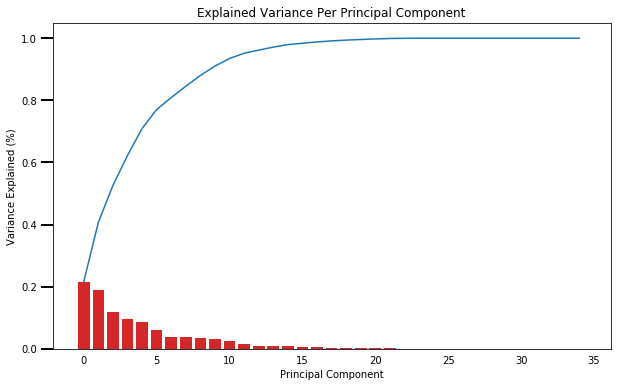

In [81]:
pca, X_train_pca_0 = do_pca(X_train_scaled)
scree_plot(pca)

We can see on the graph that if we take 15 components we will have a variance explained at almost 100%

In [82]:
# 15 components explained most variance
n_components = 15
pca, X_train_pca = do_pca(X_train_scaled, n_components=n_components)
X_train_pca.head()

,pca_comp_0,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6,pca_comp_7,pca_comp_8,pca_comp_9,pca_comp_10,pca_comp_11,pca_comp_12,pca_comp_13,pca_comp_14
10600,-3.026885,-2.788938,1.718274,-0.303544,0.546970,0.713922,0.575982,-0.219572,0.112965,-0.839885,0.248081,-0.496477,0.074330,-0.097654,0.228871
11583,3.377216,3.878425,2.197198,-1.033020,-1.470107,-0.730618,-0.874292,0.312456,-0.929713,-0.898664,0.178698,0.952845,-0.578181,0.023786,0.023645
11829,2.563271,-2.220904,-0.617368,0.423120,-0.272391,-0.156836,0.602567,-0.573764,0.175296,0.090715,-0.667741,0.182535,-0.296750,0.294789,-0.419475
21552,3.745765,2.343269,0.031223,-1.043314,-0.286214,-0.385832,0.466430,-0.584080,0.114490,0.802426,-0.155521,-1.808181,1.193789,-0.767442,-1.195996
12176,0.272861,5.828944,-0.558679,0.890704,-1.179138,-2.614289,0.594000,-1.613843,-0.721402,1.039047,4.547155,-0.300712,-1.482566,1.712420,-0.459126


In [87]:
# transform test
X_test_pca = pd.DataFrame(pca.transform(X_test_scaled))
X_test_pca.columns = ["pca_comp_" + str(i) for i in range(n_components)]
X_test_pca.index = X_test_scaled.index

In [93]:
# predict the values for the missing ages for the portion of data that has missing values
X_predict = data_predict.drop(columns=['age', 'gender', 'income', 'client_id', 'gender_F',\
                                       'gender_M', 'gender_O'])

X_predict_scaled = pd.DataFrame(ss.transform(X_predict))
X_predict_scaled.columns = X_predict.columns
X_predict_scaled.index = X_predict.index

# transform test
X_predict_pca = pd.DataFrame(pca.transform(X_predict_scaled))
X_predict_pca.columns = ["pca_comp_" + str(i) for i in range(n_components)]
X_predict_pca.index = X_predict_scaled.index

### predict age

In [83]:
Y_train = train['age']
Y_test = test['age']

In [84]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

params = {
    'max_depth': [7,8],\
    'min_child_weight': np.arange(10,510,10),\
    'n_estimators': [100,150]
}

xgb_age = xgb.XGBRegressor(learning_rate = 0.1,\
                           objective = 'reg:linear',\
                           seed = 42,\
                           gamma = 0.1,\
                           silent = True)

In [85]:
model_age = GridSearchCV(xgb_age, param_grid=params,\
                         scoring='neg_mean_squared_error', n_jobs=4,\
                         cv=skf.split(X_train_pca,Y_train),\
                         verbose=2)

model_age.fit(X_train_pca, Y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   57.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  9.4min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 16.5min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed: 25.3min finished
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


GridSearchCV(cv=<generator object _BaseKFold.split at 0x0000015DCC084248>,
             error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0.1,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs...
             param_grid={'max_depth': [7, 8],
                         'min_child_weight': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500]),
              

In [88]:
test_pred = model_age.predict(X_test_pca)
test_mse = mean_squared_error(Y_test, test_pred)
test_rmse = np.sqrt(test_mse)
print(test_rmse)

16.59273067009653


We can see that the model is not perfect, because the predicted ages are generally off by approximately 16.5 years. 
However, given the few variables at the start, the result is not so bad.

In [89]:
model_age.best_params_

{'max_depth': 7, 'min_child_weight': 460, 'n_estimators': 100}

In [90]:
save_model_name = "model_age.pickle.dat"
pickle.dump(model_age.best_estimator_, open(save_model_name, "wb"))

In [94]:
data_predict['age'] = model_age.predict(X_predict_pca)
data_predict.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,gender,age,client_id,income,member_year,member_month,member_day,offer_dis_n_offers,offer_dis_n_succ_offers,offer_dis_n_tried_offers,...,offer_tot_n_succ_offers,offer_tot_n_tried_offers,offer_tot_per_succ_offers,offer_tot_per_tried_offers,offer_tot_total_spent,offer_tot_n_trans,offer_tot_avg_spent_per_trans,gender_F,gender_M,gender_O
0,NaN,46.374722,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,10.52,6.0,1.753333,0,0,0
4,NaN,58.744556,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0,0,0
7,NaN,43.778946,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4,3.0,0.0,3.0,...,0.0,3.0,0.0,1.0,1.21,3.0,0.403333,0,0,0
9,NaN,58.587749,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,2017,9,25,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0,0,0
10,NaN,48.146412,68617ca6246f4fbc85e91a2a49552598,NaN,2017,10,2,1.0,0.0,1.0,...,0.0,2.0,0.0,2.0,0.24,2.0,0.240000,0,0,0


### predict income

In [95]:
Y_train = train['income']
Y_test = test['income']

In [96]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

params = {
    'max_depth': [7,8],\
    'min_child_weight': np.arange(10,510,10),\
    'n_estimators': [100,150]
}

xgb_income = xgb.XGBRegressor(learning_rate = 0.1,\
                              objective = 'reg:linear',\
                              seed = 42,\
                              gamma = 0.1,\
                              silent = True)

In [97]:
model_income = GridSearchCV(xgb_income, param_grid=params,\
                            scoring='neg_mean_squared_error', n_jobs=4,\
                            cv=skf.split(X_train_pca,Y_train),\
                            verbose=2)

model_income.fit(X_train_pca, Y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   57.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  7.8min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 15.0min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed: 23.6min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and wi

GridSearchCV(cv=<generator object _BaseKFold.split at 0x0000015DCCA29848>,
             error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0.1,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs...
             param_grid={'max_depth': [7, 8],
                         'min_child_weight': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500]),
              

In [98]:
test_pred = model_income.predict(X_test_pca)
test_mse = mean_squared_error(Y_test, test_pred)
test_rmse = np.sqrt(test_mse)
print(test_rmse)

14510.323842421316


We can see that the model is not perfect, because the predicted incomes are generally off by approximately 14,510 dollars. 
However, given the few variables at the start, the result is not so bad.

In [99]:
model_income.best_params_

{'max_depth': 7, 'min_child_weight': 30, 'n_estimators': 100}

In [100]:
save_model_name = "model_income.pickle.dat"
pickle.dump(model_income.best_estimator_, open(save_model_name, "wb"))

In [101]:
# fill the missing income with the predicted values
data_predict['income'] = model_income.predict(X_predict_pca)
data_predict.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,gender,age,client_id,income,member_year,member_month,member_day,offer_dis_n_offers,offer_dis_n_succ_offers,offer_dis_n_tried_offers,...,offer_tot_n_succ_offers,offer_tot_n_tried_offers,offer_tot_per_succ_offers,offer_tot_per_tried_offers,offer_tot_total_spent,offer_tot_n_trans,offer_tot_avg_spent_per_trans,gender_F,gender_M,gender_O
0,NaN,46.374722,68be06ca386d4c31939f3a4f0e3dd783,48508.757812,2017,2,12,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,10.52,6.0,1.753333,0,0,0
4,NaN,58.744556,38fe809add3b4fcf9315a9694bb96ff5,78495.625000,2018,7,12,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0,0,0
7,NaN,43.778946,a03223e636434f42ac4c3df47e8bac43,57110.437500,2017,8,4,3.0,0.0,3.0,...,0.0,3.0,0.0,1.0,1.21,3.0,0.403333,0,0,0
9,NaN,58.587749,8ec6ce2a7e7949b1bf142def7d0e0586,70251.742188,2017,9,25,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0,0,0
10,NaN,48.146412,68617ca6246f4fbc85e91a2a49552598,44621.601562,2017,10,2,1.0,0.0,1.0,...,0.0,2.0,0.0,2.0,0.24,2.0,0.240000,0,0,0


### predict gender

In [102]:
Y_train = train['gender']
Y_test = test['gender']

In [103]:
Y_train.value_counts()

M    6792
F    4904
O     164
Name: gender, dtype: int64

In [104]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

params = {
    'max_depth': [7,8],\
    'min_child_weight': np.arange(10,510,10),\
    'n_estimators': [100,150]
}

xgb_gender = xgb.XGBClassifier(learning_rate = 0.1,\
                               objective = 'multi:softmax',\
                               seed = 42,\
                               gamma = 0.1,\
                               num_class = 3,\
                               silent = True)

In [105]:
model_gender = GridSearchCV(xgb_gender, param_grid=params,\
                            scoring='f1_micro', n_jobs=4,\
                            cv=skf.split(X_train_pca,Y_train),\
                            verbose=2)

model_gender.fit(X_train_pca, Y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  9.7min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 18.4min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 31.0min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed: 52.5min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x0000015DCCA8A9C8>,
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0.1,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, num_cl...
             param_grid={'max_depth': [7, 8],
                         'min_child_weight': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500]),
       

In [106]:
#test_pred = model_gender.predict_proba(X_test_pca)
test_pred = model_gender.predict(X_test_pca)
#pd.Series(test_pred).value_counts()
#test_log_loss = log_loss(Y_test, test_pred, labels=[0,1,3])
test_f1 = f1_score(Y_test, test_pred, average='micro')
print(test_f1)

0.6026981450252951


In [107]:
model_gender.best_params_

{'max_depth': 7, 'min_child_weight': 300, 'n_estimators': 100}

In [108]:
save_model_name = "model_gender.pickle.dat"
pickle.dump(model_gender.best_estimator_, open(save_model_name, "wb"))

In [109]:
# fill the missing income with the predicted values
data_predict['gender'] = model_gender.predict(X_predict_pca)
data_predict.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,gender,age,client_id,income,member_year,member_month,member_day,offer_dis_n_offers,offer_dis_n_succ_offers,offer_dis_n_tried_offers,...,offer_tot_n_succ_offers,offer_tot_n_tried_offers,offer_tot_per_succ_offers,offer_tot_per_tried_offers,offer_tot_total_spent,offer_tot_n_trans,offer_tot_avg_spent_per_trans,gender_F,gender_M,gender_O
0,M,46.374722,68be06ca386d4c31939f3a4f0e3dd783,48508.757812,2017,2,12,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,10.52,6.0,1.753333,0,0,0
4,M,58.744556,38fe809add3b4fcf9315a9694bb96ff5,78495.625000,2018,7,12,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0,0,0
7,M,43.778946,a03223e636434f42ac4c3df47e8bac43,57110.437500,2017,8,4,3.0,0.0,3.0,...,0.0,3.0,0.0,1.0,1.21,3.0,0.403333,0,0,0
9,M,58.587749,8ec6ce2a7e7949b1bf142def7d0e0586,70251.742188,2017,9,25,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0,0,0
10,M,48.146412,68617ca6246f4fbc85e91a2a49552598,44621.601562,2017,10,2,1.0,0.0,1.0,...,0.0,2.0,0.0,2.0,0.24,2.0,0.240000,0,0,0


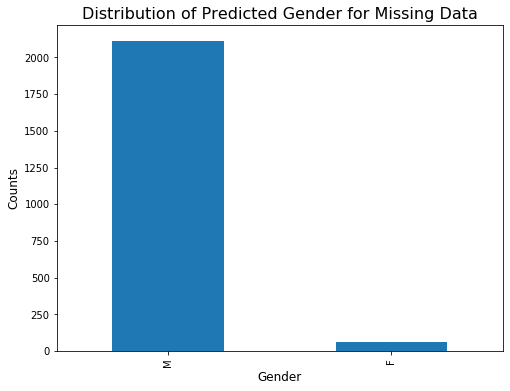

In [110]:
# Distribution of predicted genders
fig, ax = plt.subplots(figsize=(8,6));
data_predict.gender.value_counts().plot(kind='bar', ax=ax)
ax.set_title("Distribution of Predicted Gender for Missing Data", fontsize=16)
ax.set_xlabel("Gender", fontsize=12);
ax.set_ylabel("Counts", fontsize=12);

We can see that the model is not perfect, because the predicted genders are generally Male (almost 90%). 
However, given the few variables at the start, the result is not so bad, but we can ask ourselves if the low representation of women in the starting base is not the cause of this.

### Fill missing values

In [111]:
# data without missing values
data_no_missing =all_data[~(pd.isnull(all_data['income']))]
# data with missing values
data_missing = all_data[pd.isnull(all_data['income'])]

In [115]:
data_missing.head()

,gender,age,client_id,income,member_year,member_month,member_day,offer_dis_n_offers,offer_dis_n_succ_offers,offer_dis_n_tried_offers,...,offer_tot_n_succ_offers,offer_tot_n_tried_offers,offer_tot_per_succ_offers,offer_tot_per_tried_offers,offer_tot_total_spent,offer_tot_n_trans,offer_tot_avg_spent_per_trans,gender_F,gender_M,gender_O
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,10.52,6.0,1.753333,0,0,0
4,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0,0,0
7,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4,3.0,0.0,3.0,...,0.0,3.0,0.0,1.0,1.21,3.0,0.403333,0,0,0
9,NaN,NaN,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,2017,9,25,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0,0,0
10,NaN,NaN,68617ca6246f4fbc85e91a2a49552598,NaN,2017,10,2,1.0,0.0,1.0,...,0.0,2.0,0.0,2.0,0.24,2.0,0.240000,0,0,0


In [118]:
data_missing = data_missing[['client_id', 'member_year', 'member_month', 'member_day']]

In [120]:
data_predict_summary = data_predict[['age', 'gender', 'income', 'client_id']]
new_profile_w_missing = pd.merge(data_missing, data_predict_summary, on='client_id', how='left')
new_profile_w_missing = new_profile_w_missing[['age', 'gender', 'income', 'client_id', 'member_year', 'member_month', 'member_day']]
new_profile_w_missing.head()

,age,gender,income,client_id,member_year,member_month,member_day
0,46.374722,M,48508.757812,68be06ca386d4c31939f3a4f0e3dd783,2017,2,12
1,58.744556,M,78495.625000,38fe809add3b4fcf9315a9694bb96ff5,2018,7,12
2,43.778946,M,57110.437500,a03223e636434f42ac4c3df47e8bac43,2017,8,4
3,58.587749,M,70251.742188,8ec6ce2a7e7949b1bf142def7d0e0586,2017,9,25
4,48.146412,M,44621.601562,68617ca6246f4fbc85e91a2a49552598,2017,10,2


In [121]:
new_profile_w_missing.shape

(2175, 7)

In [123]:
data_no_missing = data_no_missing[['age', 'gender', 'income', 'client_id', 'member_year', 'member_month', 'member_day']]

In [124]:
# combine both the datasets together
new_profile = pd.concat([data_no_missing, new_profile_w_missing], axis=0)
new_profile.head()

,age,gender,income,client_id,member_year,member_month,member_day
3,55.0,F,112000.0,0610b486422d4921ae7d2bf64640c50b,2017,7,15
5,75.0,F,100000.0,78afa995795e4d85b5d9ceeca43f5fef,2017,5,9
8,68.0,M,70000.0,e2127556f4f64592b11af22de27a7932,2018,4,26
11,65.0,M,53000.0,389bc3fa690240e798340f5a15918d5c,2018,2,9
20,58.0,M,51000.0,2eeac8d8feae4a8cad5a6af0499a211d,2017,11,11


In [125]:
new_profile.shape

(17000, 7)

# EDA (Exploratory Data Analytics)

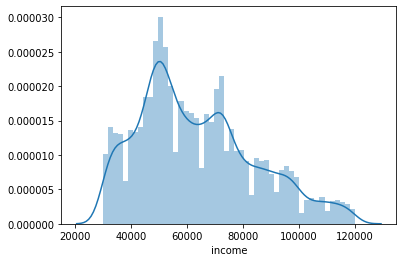

In [130]:
# customer income
sns.distplot(new_profile['income'], bins=50, hist_kws={'alpha': 0.4});

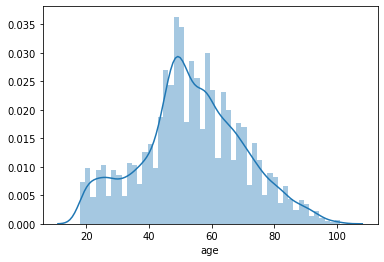

In [131]:
# customer age
sns.distplot(new_profile['age'], bins=50, hist_kws={'alpha': 0.4});

There are few people with less than 40 years old, and in the same time, the income is often greater than 40,000

In [ ]:
# Merge new_profile with offers summary

In [132]:
offers_summary.head()

,client_id,offer_id,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers,n_failed_offers,offer_id2,n_offers
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,8.57,1,8.57,0,1,0,informational_1,1
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,22.16,1,22.16,0,1,0,informational_2,1
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,22.05,1,22.05,1,0,0,discount_1,1
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11.93,1,11.93,1,0,0,discount_2,1
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05,1,22.05,1,0,0,bogo_2,1


In [133]:
new_offers_summary = pd.merge(offers_summary, new_profile, on='client_id', how='left')

In [134]:
new_offers_summary.head()

,client_id,offer_id,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers,n_failed_offers,offer_id2,n_offers,age,gender,income,member_year,member_month,member_day
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,8.57,1,8.57,0,1,0,informational_1,1,33.0,M,72000.0,2017,4,21
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,22.16,1,22.16,0,1,0,informational_2,1,33.0,M,72000.0,2017,4,21
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,22.05,1,22.05,1,0,0,discount_1,1,40.0,O,57000.0,2018,1,9
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11.93,1,11.93,1,0,0,discount_2,1,40.0,O,57000.0,2018,1,9
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05,1,22.05,1,0,0,bogo_2,1,40.0,O,57000.0,2018,1,9


In [138]:
new_offers_summary["n_offers"].sum()

49675

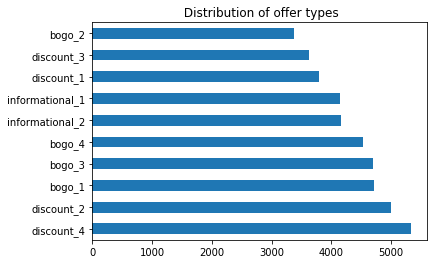

In [140]:
new_offers_summary['offer_id2'].value_counts().plot.barh(title=' Distribution of offer types')

We can see that there are not a big difference in the offer type distribution. 
We can just notice that the discount offer seem to be more successful. 

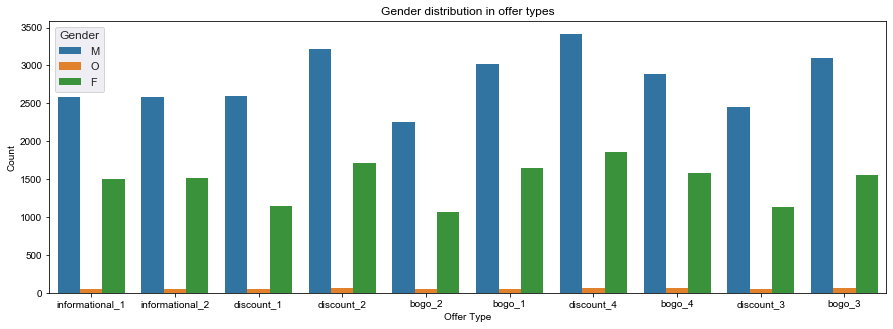

In [141]:
# Gender distribution in each offer type
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_id2", hue= "gender", data=new_offers_summary)
sns.set(style="darkgrid")
plt.title('Gender distribution in offer types')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')

The distribution gender is the same for all the offers

In [144]:
new_kind_offers_summary = pd.merge(new_offers_summary, portfolio_df, on='offer_id', how='left')

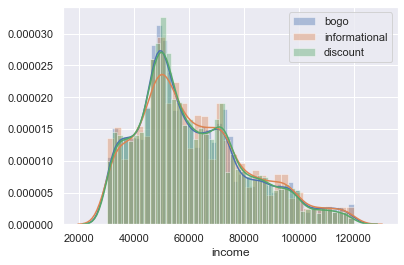

In [145]:
## offer type-wise Income Distribution
sns.distplot(new_kind_offers_summary[new_kind_offers_summary.offer_type=='bogo'].income,label='bogo')
sns.distplot(new_kind_offers_summary[new_kind_offers_summary.offer_type=='informational'].income,label='informational')
sns.distplot(new_kind_offers_summary[new_kind_offers_summary.offer_type=='discount'].income,label='discount')
plt.legend()
plt.show()

The three offers seem to have the same income distribution

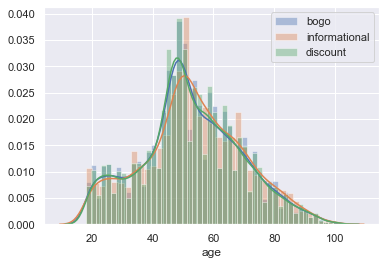

In [408]:
## offer type-age Distribution
sns.distplot(new_kind_offers_summary[new_kind_offers_summary.offer_type=='bogo'].age,label='bogo')
sns.distplot(new_kind_offers_summary[new_kind_offers_summary.offer_type=='informational'].age,label='informational')
sns.distplot(new_kind_offers_summary[new_kind_offers_summary.offer_type=='discount'].age,label='discount')
plt.legend()
plt.show()

The three offers seem to have the same age distribution

In [181]:
new_kind_offers_summary_suc = new_kind_offers_summary[(new_kind_offers_summary["n_succ_offers"] > 0) | (new_kind_offers_summary["n_tried_offers"] > 0)]

In [182]:
new_kind_offers_summary_suc = new_kind_offers_summary_suc[(new_kind_offers_summary_suc["avg_spent_offer_trans"] < 50)]

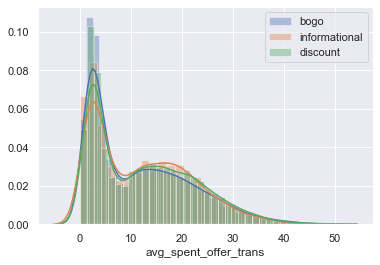

In [155]:
## offer type-total_offer_spent Distribution
sns.distplot(new_kind_offers_summary_suc[new_kind_offers_summary_suc.offer_type=='bogo'].avg_spent_offer_trans,label='bogo')
sns.distplot(new_kind_offers_summary_suc[new_kind_offers_summary_suc.offer_type=='informational'].avg_spent_offer_trans,label='informational')
sns.distplot(new_kind_offers_summary_suc[new_kind_offers_summary_suc.offer_type=='discount'].avg_spent_offer_trans,label='discount')
plt.legend()
plt.show()

The bogo offer seems to have clients who don't want to spent a lot of money

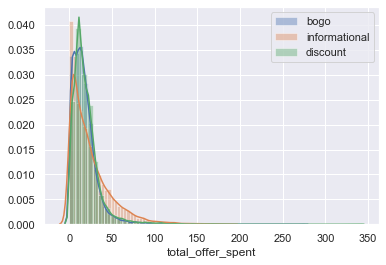

In [156]:
## offer type-total_offer_spent Distribution
sns.distplot(new_kind_offers_summary_suc[new_kind_offers_summary_suc.offer_type=='bogo'].total_offer_spent,label='bogo')
sns.distplot(new_kind_offers_summary_suc[new_kind_offers_summary_suc.offer_type=='informational'].total_offer_spent,label='informational')
sns.distplot(new_kind_offers_summary_suc[new_kind_offers_summary_suc.offer_type=='discount'].total_offer_spent,label='discount')
plt.legend()
plt.show()

It's a confirmation : the bogo offer seems to have clients who don't want to spent a lot of money especially in comparaison with informational

### Create profit to understant what offer is more avantageous for Starbucks

In [157]:
new_kind_offers_summary_suc.head()

,client_id,offer_id,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers,n_failed_offers,offer_id2,n_offers,...,member_month,member_day,reward,difficulty,duration,offer_type,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,8.57,1,8.57,0,1,0,informational_1,1,...,4,21,0,0,4,informational,1,1,0,1
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,22.16,1,22.16,0,1,0,informational_2,1,...,4,21,0,0,3,informational,1,1,1,0
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,22.05,1,22.05,1,0,0,discount_1,1,...,1,9,5,20,10,discount,1,0,0,1
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11.93,1,11.93,1,0,0,discount_2,1,...,1,9,3,7,7,discount,1,1,1,1
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05,1,22.05,1,0,0,bogo_2,1,...,1,9,5,5,7,bogo,1,1,0,1


In [183]:
new_kind_offers_summary_suc = new_kind_offers_summary_suc[new_kind_offers_summary_suc["offer_type"].isin(["discount","bogo"])]

In [180]:
new_kind_offers_summary_suc.head()

,client_id,offer_id,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers,n_failed_offers,offer_id2,n_offers,...,web,cost,profit,has_profit,gender_F,gender_M,gender_O,gender_F,gender_M,gender_O
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,22.05,1,22.05,1,0,0,discount_1,1,...,1,5.0,17.05,1.0,0,0,1,0,0,1
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11.93,1,11.93,1,0,0,discount_2,1,...,1,3.0,8.93,1.0,0,0,1,0,0,1
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05,1,22.05,1,0,0,bogo_2,1,...,1,5.0,17.05,1.0,0,0,1,0,0,1
5,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,17.24,1,17.24,1,0,0,bogo_1,1,...,1,10.0,7.24,1.0,1,0,0,1,0,0
7,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,17.63,1,17.63,1,0,0,discount_4,1,...,1,2.0,15.63,1.0,1,0,0,1,0,0


In [184]:
monthly_data_cost = []

for row, col in new_kind_offers_summary_suc.iterrows():
    # if individual successfully completed the offer
    if col['total_offer_spent'] > col['difficulty']:
        cost = col['n_offers'] * col['reward']
        monthly_data_cost.append(cost)
    else:
        monthly_data_cost.append(0.0)
        
new_kind_offers_summary_suc['cost'] = monthly_data_cost

In [185]:
new_kind_offers_summary_suc['profit'] = new_kind_offers_summary_suc['total_offer_spent'] - new_kind_offers_summary_suc['cost']
has_profit = np.zeros(new_kind_offers_summary_suc.shape[0])
has_profit[np.where(new_kind_offers_summary_suc['profit'] > 0)] = 1
new_kind_offers_summary_suc['has_profit'] = has_profit
new_kind_offers_summary_suc.drop(columns=['reward', 'difficulty'], inplace=True)
new_kind_offers_summary_suc.head()

,client_id,offer_id,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers,n_failed_offers,offer_id2,n_offers,...,member_day,duration,offer_type,email,mobile,social,web,cost,profit,has_profit
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,22.05,1,22.05,1,0,0,discount_1,1,...,9,10,discount,1,0,0,1,5.0,17.05,1.0
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11.93,1,11.93,1,0,0,discount_2,1,...,9,7,discount,1,1,1,1,3.0,8.93,1.0
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05,1,22.05,1,0,0,bogo_2,1,...,9,7,bogo,1,1,0,1,5.0,17.05,1.0
5,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,17.24,1,17.24,1,0,0,bogo_1,1,...,4,5,bogo,1,1,1,1,10.0,7.24,1.0
7,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,17.63,1,17.63,1,0,0,discount_4,1,...,4,10,discount,1,1,1,1,2.0,15.63,1.0


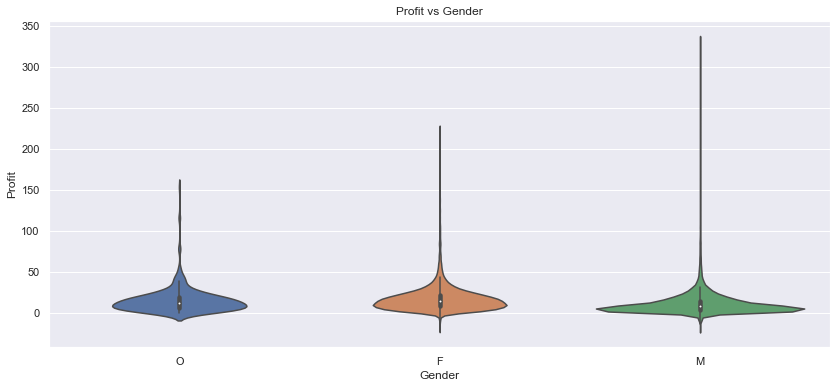

In [169]:
# profit vs gender
plt.figure(figsize=(14, 6))
sns.violinplot(x=new_kind_offers_summary_suc[new_kind_offers_summary_suc['gender'] != 'NA']['gender'], y=new_kind_offers_summary_suc['profit'])
plt.title('Profit vs Gender')
plt.ylabel('Profit')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

We can notice that men bring small profits (even if there are big outliers) in comparaison with women

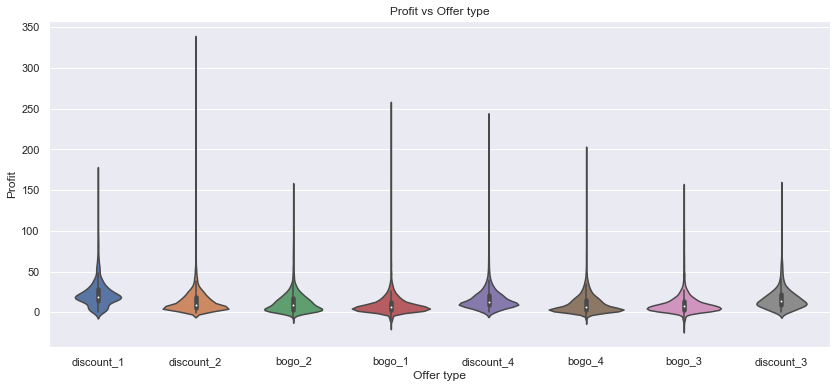

In [170]:
# profit vs Offer type
plt.figure(figsize=(14, 6))
sns.violinplot(x=new_kind_offers_summary_suc[new_kind_offers_summary_suc['offer_id2'] != 'NA']['offer_id2'], y=new_kind_offers_summary_suc['profit'])
plt.title('Profit vs Offer type')
plt.ylabel('Profit')
plt.xlabel('Offer type')
plt.xticks(rotation = 0)
plt.show();

The discount offers are more probe to generate bigger profit than bogo offers

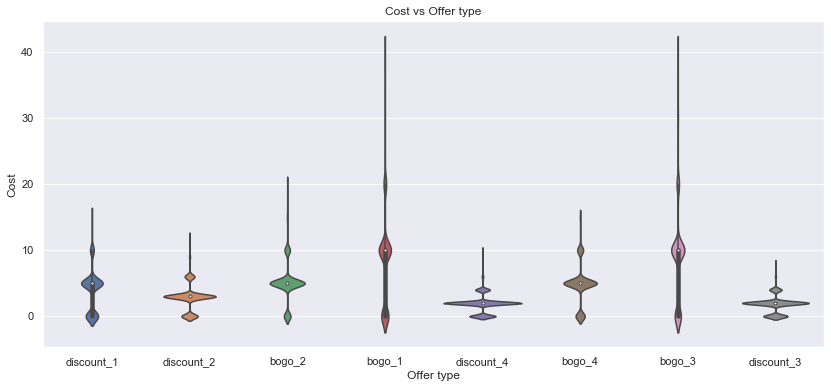

In [171]:
# Cost vs Offer type
plt.figure(figsize=(14, 6))
sns.violinplot(x=new_kind_offers_summary_suc[new_kind_offers_summary_suc['offer_id2'] != 'NA']['offer_id2'], y=new_kind_offers_summary_suc['cost'])
plt.title('Cost vs Offer type')
plt.ylabel('Cost')
plt.xlabel('Offer type')
plt.xticks(rotation = 0)
plt.show();

The bogo offers are more risky, their costs are bigger than others

# Model

We want to found out what offers is more profitable between bogo and discount, and what variables are important in these two offers

## Model Bogo

In [173]:
new_kind_offers_summary_suc.columns

Index(['client_id', 'offer_id', 'total_offer_spent', 'total_num_offer_trans',
       'avg_spent_offer_trans', 'n_succ_offers', 'n_tried_offers',
       'n_failed_offers', 'offer_id2', 'n_offers', 'age', 'gender', 'income',
       'member_year', 'member_month', 'member_day', 'duration', 'offer_type',
       'email', 'mobile', 'social', 'web', 'cost', 'profit', 'has_profit'],
      dtype='object')

In [186]:
# one-hot encode gender
cat_var_to_enc = ['gender']

for var in cat_var_to_enc:
    new_kind_offers_summary_suc = pd.concat([new_kind_offers_summary_suc,\
                          pd.get_dummies(new_kind_offers_summary_suc[var],\
                                         prefix=var, prefix_sep='_', drop_first=False)], axis=1)
new_kind_offers_summary_suc.head()

,client_id,offer_id,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers,n_failed_offers,offer_id2,n_offers,...,email,mobile,social,web,cost,profit,has_profit,gender_F,gender_M,gender_O
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,22.05,1,22.05,1,0,0,discount_1,1,...,1,0,0,1,5.0,17.05,1.0,0,0,1
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11.93,1,11.93,1,0,0,discount_2,1,...,1,1,1,1,3.0,8.93,1.0,0,0,1
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05,1,22.05,1,0,0,bogo_2,1,...,1,1,0,1,5.0,17.05,1.0,0,0,1
5,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,17.24,1,17.24,1,0,0,bogo_1,1,...,1,1,1,1,10.0,7.24,1.0,1,0,0
7,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,17.63,1,17.63,1,0,0,discount_4,1,...,1,1,1,1,2.0,15.63,1.0,1,0,0


In [228]:
features = ['age', 'gender_F','gender_M','gender_O', 'income',
       'member_year', 'member_month', 'member_day', 'duration', 
       'email', 'mobile', 'social', 'web', 'total_offer_spent', 'total_num_offer_trans',
       'avg_spent_offer_trans', 'n_succ_offers', 'n_tried_offers']
target = "profit"

In [188]:
# We create a bogo data to create a bogo model 
data_bogo = new_kind_offers_summary_suc[new_kind_offers_summary_suc["offer_type"].isin(["bogo"])]

In [229]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data_bogo[features] = scaler.fit_transform(data_bogo[features])
data_bogo.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,client_id,offer_id,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers,n_failed_offers,offer_id2,n_offers,...,email,mobile,social,web,cost,profit,has_profit,gender_F,gender_M,gender_O
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.080248,0.0,0.443280,0.25,0.0,0,bogo_2,1,...,0.0,0.0,0.0,1.0,0.125,17.05,1.0,0.0,0.0,1.0
5,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,0.062703,0.0,0.346363,0.25,0.0,0,bogo_1,1,...,0.0,0.0,1.0,1.0,0.250,7.24,1.0,1.0,0.0,0.0
10,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.037461,0.0,0.206931,0.25,0.0,0,bogo_2,1,...,0.0,0.0,0.0,1.0,0.125,5.32,1.0,1.0,0.0,0.0
11,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,0.052818,0.0,0.291759,0.25,0.0,0,bogo_4,1,...,0.0,0.0,1.0,1.0,0.125,9.53,1.0,1.0,0.0,0.0
19,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,0.101660,0.0,0.561556,0.25,0.0,0,bogo_4,1,...,0.0,0.0,1.0,1.0,0.125,22.92,1.0,1.0,0.0,0.0


In [230]:
X_train, X_test, y_train, y_test = train_test_split(data_bogo[features], data_bogo[target], random_state=0)

In [213]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (12105, 19)
Training Labels Shape: (12105,)
Testing Features Shape: (4035, 19)
Testing Labels Shape: (4035,)


In [210]:
data_bogo["has_profit"].shape

(16140,)

### Random Forest

In [252]:
ForestRegressor = RandomForestRegressor(n_estimators=500)
ForestRegressor.fit(X_train, y_train)
y_test_preds = ForestRegressor.predict(X_test)

In [254]:
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
r2 = r2_score(y_test.values.ravel(), y_test_preds)
print('R-squared scores:', round(r2, 2))

R-squared scores: 0.97


The r-squered is very high. We don't need to test another model.

In [255]:
# Import library for metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), y_test_preds)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), y_test_preds)

print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))

Mean Absolute Error: 1.31
Mean Squared Error: 5.71


In [256]:
# Analysing the coefs to understand what variables are important 
coefs_df = pd.DataFrame()

coefs_df['Features'] = X_train.columns
coefs_df['Coefs'] = ForestRegressor.feature_importances_
coefs_df.sort_values('Coefs', ascending=False).head(15)

,Features,Coefs
13,total_offer_spent,0.918272
15,avg_spent_offer_trans,0.034335
17,n_tried_offers,0.011594
11,social,0.005576
12,web,0.005174
4,income,0.004929
16,n_succ_offers,0.004658
0,age,0.004173
7,member_day,0.003740
6,member_month,0.002627


We can see the amount of money spend during the offer period is very important to predict the bogo profit.
Unfortunately, it's a little obvious. We will try the model without these variables.

In [270]:
features2 = ['age', 'gender_F','gender_M','gender_O', 'income',
       'member_year', 'member_month', 'member_day', 'duration', 
       'email', 'mobile', 'social', 'web', 
       'total_num_offer_trans', 'n_succ_offers', 'n_tried_offers']

In [271]:
X_train, X_test, y_train, y_test = train_test_split(data_bogo[features2], data_bogo[target], random_state=0)

In [272]:
ForestRegressor = RandomForestRegressor(n_estimators=500)
ForestRegressor.fit(X_train, y_train)
y_test_preds = ForestRegressor.predict(X_test)

In [273]:
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
r2 = r2_score(y_test.values.ravel(), y_test_preds)
print('R-squared scores:', round(r2, 2))

R-squared scores: 0.46


The r-squared score is not perfect, but it's normal without some important features.

In [268]:
# Import library for metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), y_test_preds)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), y_test_preds)

print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))

Mean Absolute Error: 3.81
Mean Squared Error: 60.85


In [274]:
# Analysing the coefs to understand what variables are important 
coefs_df = pd.DataFrame()

coefs_df['Features'] = X_train.columns
coefs_df['Coefs'] = ForestRegressor.feature_importances_
coefs_df.sort_values('Coefs', ascending=False).head(15)

,Features,Coefs
13,total_num_offer_trans,0.306399
4,income,0.269163
14,n_succ_offers,0.092483
0,age,0.091891
7,member_day,0.071194
6,member_month,0.060683
5,member_year,0.037497
15,n_tried_offers,0.016012
12,web,0.015805
11,social,0.013611


We can see that the income of client is important, and the number of offers. 
It seems probably that Starbucks should target the high income clients, and don't hesitate to make many offers.

## Model Discount

In [276]:
# We create a discount data to create a discount model 
data_dis = new_kind_offers_summary_suc[new_kind_offers_summary_suc["offer_type"].isin(["discount"])]

In [278]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data_dis[features] = scaler.fit_transform(data_dis[features])
data_dis.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,client_id,offer_id,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers,n_failed_offers,offer_id2,n_offers,...,email,mobile,social,web,cost,profit,has_profit,gender_F,gender_M,gender_O
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.064721,0.0000,0.441147,0.25,0.0,0,discount_1,1,...,0.0,0.0,0.0,0.0,5.0,17.05,1.0,0.0,0.0,1.0
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,0.034949,0.0000,0.238219,0.25,0.0,0,discount_2,1,...,0.0,1.0,1.0,0.0,3.0,8.93,1.0,0.0,0.0,1.0
7,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,0.051718,0.0000,0.352517,0.25,0.0,0,discount_4,1,...,0.0,1.0,1.0,0.0,2.0,15.63,1.0,1.0,0.0,0.0
8,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,0.034126,0.0000,0.232605,0.25,0.0,0,discount_2,1,...,0.0,1.0,1.0,0.0,3.0,8.65,1.0,1.0,0.0,0.0
14,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,0.070311,0.5625,0.047022,0.50,0.0,0,discount_4,2,...,0.0,1.0,1.0,0.0,4.0,19.95,1.0,1.0,0.0,0.0


In [279]:
X_train, X_test, y_train, y_test = train_test_split(data_dis[features], data_dis[target], random_state=0)

In [280]:
ForestRegressor = RandomForestRegressor(n_estimators=500)
ForestRegressor.fit(X_train, y_train)
y_test_preds = ForestRegressor.predict(X_test)

In [281]:
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
r2 = r2_score(y_test.values.ravel(), y_test_preds)
print('R-squared scores:', round(r2, 2))

R-squared scores: 1.0


As bogo model, the r-squared score is very high.

In [282]:
# Import library for metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), y_test_preds)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), y_test_preds)

print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))

Mean Absolute Error: 0.2
Mean Squared Error: 0.48


In [283]:
# Analysing the coefs to understand what variables are important 
coefs_df = pd.DataFrame()

coefs_df['Features'] = X_train.columns
coefs_df['Coefs'] = ForestRegressor.feature_importances_
coefs_df.sort_values('Coefs', ascending=False).head(15)

,Features,Coefs
13,total_offer_spent,0.989809
15,avg_spent_offer_trans,0.003810
10,mobile,0.001283
16,n_succ_offers,0.001191
17,n_tried_offers,0.000892
8,duration,0.000552
4,income,0.000545
7,member_day,0.000474
11,social,0.000449
0,age,0.000393


As bogo model, the money spent is too important.
We will try an another model.

In [284]:
X_train, X_test, y_train, y_test = train_test_split(data_dis[features2], data_dis[target], random_state=0)

In [285]:
ForestRegressor = RandomForestRegressor(n_estimators=500)
ForestRegressor.fit(X_train, y_train)
y_test_preds = ForestRegressor.predict(X_test)

In [286]:
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
r2 = r2_score(y_test.values.ravel(), y_test_preds)
print('R-squared scores:', round(r2, 2))

R-squared scores: 0.59


The r-squared score is better than bogo model. 0.59 is pretty good.

In [287]:
# Import library for metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), y_test_preds)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), y_test_preds)

print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))

Mean Absolute Error: 5.45
Mean Squared Error: 109.64


In [288]:
# Analysing the coefs to understand what variables are important 
coefs_df = pd.DataFrame()

coefs_df['Features'] = X_train.columns
coefs_df['Coefs'] = ForestRegressor.feature_importances_
coefs_df.sort_values('Coefs', ascending=False).head(15)

,Features,Coefs
14,n_succ_offers,0.251029
4,income,0.246616
13,total_num_offer_trans,0.176260
0,age,0.098794
7,member_day,0.056387
6,member_month,0.040969
10,mobile,0.030350
5,member_year,0.029005
15,n_tried_offers,0.027561
8,duration,0.015572


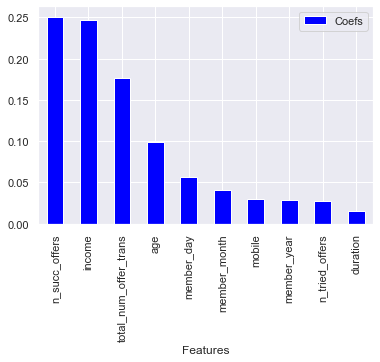

In [296]:
# Creating a graph to understand in a better way
coefs_df.set_index('Features', inplace=True)
coefs_df.sort_values('Coefs', ascending=False).head(10).plot(kind='bar', color='blue')

As bogo model, we can see that the income of client is important, and the number of offers. 
It seems probably that Starbucks should target the high income clients, and don't hesitate to make many offers.

### How to win a lot of profit

We will create variable to find out if the offer type is important to make profit.

In [297]:
new_kind_offers_summary_suc.head()

,client_id,offer_id,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers,n_failed_offers,offer_id2,n_offers,...,email,mobile,social,web,cost,profit,has_profit,gender_F,gender_M,gender_O
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,22.05,1,22.05,1,0,0,discount_1,1,...,1,0,0,1,5.0,17.05,1.0,0,0,1
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11.93,1,11.93,1,0,0,discount_2,1,...,1,1,1,1,3.0,8.93,1.0,0,0,1
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05,1,22.05,1,0,0,bogo_2,1,...,1,1,0,1,5.0,17.05,1.0,0,0,1
5,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,17.24,1,17.24,1,0,0,bogo_1,1,...,1,1,1,1,10.0,7.24,1.0,1,0,0
7,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,17.63,1,17.63,1,0,0,discount_4,1,...,1,1,1,1,2.0,15.63,1.0,1,0,0


In [300]:
# one-hot encode type offer
cat_var_to_enc = ['offer_type']

for var in cat_var_to_enc:
    new_kind_offers_summary_suc = pd.concat([new_kind_offers_summary_suc,\
                          pd.get_dummies(new_kind_offers_summary_suc[var],\
                                         prefix=var, prefix_sep='_', drop_first=False)], axis=1)
new_kind_offers_summary_suc.head()

,client_id,offer_id,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers,n_failed_offers,offer_id2,n_offers,...,social,web,cost,profit,has_profit,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,22.05,1,22.05,1,0,0,discount_1,1,...,0,1,5.0,17.05,1.0,0,0,1,0,1
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11.93,1,11.93,1,0,0,discount_2,1,...,1,1,3.0,8.93,1.0,0,0,1,0,1
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05,1,22.05,1,0,0,bogo_2,1,...,0,1,5.0,17.05,1.0,0,0,1,1,0
5,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,17.24,1,17.24,1,0,0,bogo_1,1,...,1,1,10.0,7.24,1.0,1,0,0,1,0
7,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,17.63,1,17.63,1,0,0,discount_4,1,...,1,1,2.0,15.63,1.0,1,0,0,0,1


In [306]:
# mean of profit
new_kind_offers_summary_suc['profit'].mean()

13.547285918792378

In [366]:
# We create a binary variable to see if a offer has had a "big" profit (higher than 15) 

data_profit = []

for row, col in new_kind_offers_summary_suc.iterrows():
    # if individual successfully completed the offer
    if col['profit'] >= 15:
        data_profit.append(2)
    else:
        data_profit.append(1)
        
new_kind_offers_summary_suc['big_profit'] = data_profit

In [367]:
new_kind_offers_summary_suc.head()

,client_id,offer_id,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers,n_failed_offers,offer_id2,n_offers,...,web,cost,profit,has_profit,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,big_profit
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,22.05,1,22.05,1,0,0,discount_1,1,...,1,5.0,17.05,1.0,0,0,1,0,1,2
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11.93,1,11.93,1,0,0,discount_2,1,...,1,3.0,8.93,1.0,0,0,1,0,1,1
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05,1,22.05,1,0,0,bogo_2,1,...,1,5.0,17.05,1.0,0,0,1,1,0,2
5,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,17.24,1,17.24,1,0,0,bogo_1,1,...,1,10.0,7.24,1.0,1,0,0,1,0,1
7,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,17.63,1,17.63,1,0,0,discount_4,1,...,1,2.0,15.63,1.0,1,0,0,0,1,2


In [309]:
new_kind_offers_summary_suc.columns

Index(['client_id', 'offer_id', 'total_offer_spent', 'total_num_offer_trans',
       'avg_spent_offer_trans', 'n_succ_offers', 'n_tried_offers',
       'n_failed_offers', 'offer_id2', 'n_offers', 'age', 'gender', 'income',
       'member_year', 'member_month', 'member_day', 'duration', 'offer_type',
       'email', 'mobile', 'social', 'web', 'cost', 'profit', 'has_profit',
       'gender_F', 'gender_M', 'gender_O', 'offer_type_bogo',
       'offer_type_discount', 'big_profit'],
      dtype='object')

In [368]:
# Split the data into features and target label
target = new_kind_offers_summary_suc['big_profit']
features_data = new_kind_offers_summary_suc[['n_offers', 'age', 'income',
       'member_year', 'member_month', 'member_day', 'duration', 
       'email', 'mobile', 'social', 'web', 'cost',
       'gender_F', 'gender_M', 'gender_O', 'offer_type_bogo',
       'offer_type_discount']]
features = ['n_offers', 'age', 'income',
       'member_year', 'member_month', 'member_day', 'duration', 
       'email', 'mobile', 'social', 'web', 'cost',
       'gender_F', 'gender_M', 'gender_O', 'offer_type_bogo',
       'offer_type_discount']

In [369]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

features_data[features] = scaler.fit_transform(features_data[features])
features_data.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,n_offers,age,income,member_year,member_month,member_day,duration,email,mobile,social,web,cost,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount
2,0.0,0.265060,0.300000,1.0,0.000000,0.266667,1.0,0.0,0.0,0.0,1.0,0.125,0.0,0.0,1.0,0.0,1.0
3,0.0,0.265060,0.300000,1.0,0.000000,0.266667,0.4,0.0,1.0,1.0,1.0,0.075,0.0,0.0,1.0,0.0,1.0
4,0.0,0.265060,0.300000,1.0,0.000000,0.266667,0.4,0.0,1.0,0.0,1.0,0.125,0.0,0.0,1.0,1.0,0.0
5,0.0,0.493976,0.666667,0.6,0.181818,0.100000,0.0,0.0,1.0,1.0,1.0,0.250,1.0,0.0,0.0,1.0,0.0
7,0.0,0.493976,0.666667,0.6,0.181818,0.100000,1.0,0.0,1.0,1.0,1.0,0.050,1.0,0.0,0.0,0.0,1.0


In [370]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(features_data, target, random_state=0)

In [371]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (23052, 17)
Training Labels Shape: (23052,)
Testing Features Shape: (7684, 17)
Testing Labels Shape: (7684,)


In [373]:
def pred_score(model):
    pred = model.predict(X_test)
    # Calculate the absolute errors
    errors = abs(pred - y_test)
    # Calculate mean absolute percentage error
    mape = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mape)
    return round(accuracy, 2)

We will test some models

In [374]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train, y_train)

print(f'Accuracy of Logistic regression classifier on training set: {round(logreg.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(logreg)}%')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of Logistic regression classifier on training set: 81.62%.
Prediction Accuracy: 88.06%


In [375]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier().fit(X_train, y_train)

print(f'Accuracy of K-NN classifier on training set: {round(knn.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(knn)}%')

Accuracy of K-NN classifier on training set: 85.63%.
Prediction Accuracy: 86.56%


In [389]:
from sklearn.svm import SVC

svm = SVC(kernel='linear').fit(X_train, y_train)

print(f'Accuracy of SVM classifier on training set: {round(svm.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(svm)}%')

Accuracy of SVM classifier on training set: 81.62%.
Prediction Accuracy: 87.93%


In [378]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier().fit(X_train, y_train)

print(f'Accuracy of Decision Tree classifier on training set: {round(dt.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(dt)}%')

Accuracy of Decision Tree classifier on training set: 100.0%.
Prediction Accuracy: 82.48%


In [390]:
# reference: https://stackoverflow.com/a/52768022
models = [logreg, knn, dt, svm]
model_names = [type(n).__name__ for n in models]
tr_accuracy = [x.score(X_train, y_train)*100 for x in models]
pred_accuracy = [pred_score(y) for y in models]

In [391]:
results = [tr_accuracy, pred_accuracy]
results_df = pd.DataFrame(results, columns = model_names, index=['Training Accuracy', 'Predicting Accuracy']) 
results_df

,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,SVC
Training Accuracy,81.615478,85.628145,100.00,81.624154
Predicting Accuracy,88.060000,86.560000,82.48,87.930000


The best model is the logistic regression model, but all models are very good.

In [383]:
print(logreg.coef_)

[[ 4.25885065e+00  5.51400623e-01  5.37400567e+00 -5.13685879e-01
   1.52547185e-03 -4.52264398e-02  1.02654484e+00  0.00000000e+00
  -9.22812157e-01 -6.13939407e-01  7.62966691e-01  5.09032713e+00
  -3.63898296e-01 -9.84995093e-01 -3.83215690e-01 -1.42305138e+00
  -3.09057699e-01]]


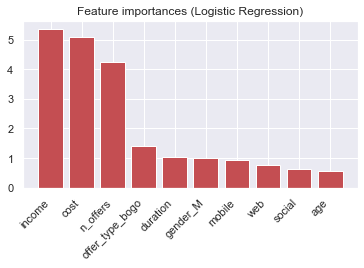

In [384]:
coefs = np.abs(logreg.coef_[0])
indices = np.argsort(coefs)[::-1]

plt.figure()
plt.title("Feature importances (Logistic Regression)")
plt.bar(range(10), coefs[indices[:10]],
       color="r", align="center")
plt.xticks(range(10), X_train.columns[indices[:10]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

We can see income of clients and cost of offers are very important. 
We can notice the fourth variable : offer_type_bogo. It could be a good indication to show off that bogo is better than discount offer.

In [392]:
print(svm.coef_)

[[ 3.61559407  0.4250617   4.25607007 -0.34304834  0.02690827 -0.02295734
   0.71841307  0.         -0.72591228 -0.41333593  0.56313635  2.61682318
   0.15165395 -0.27457677  0.12292282 -0.3517984   0.3517984 ]]


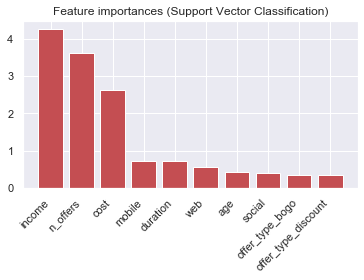

In [393]:
coefs = np.abs(svm.coef_[0])
indices = np.argsort(coefs)[::-1]

plt.figure()
plt.title("Feature importances (Support Vector Classification)")
plt.bar(range(10), coefs[indices[:10]],
       color="r", align="center")
plt.xticks(range(10), X_train.columns[indices[:10]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

We observe the result of SVC model, because it was very close from logistic regression result.
We can see income of clients and cost of offers are very important. 
We can notice the offer_type_bogo is lower in the ranking, but ahead of discount offer. It could be a good indication to show off that bogo is better than discount offer.

# Conclusion

We try an another model without the variables directly related to the offers.

In [394]:
features_data2 = new_kind_offers_summary_suc[[ 'age',
       'member_year', 'member_month', 'member_day', 'duration', 
       'email', 'mobile', 'social', 'web',
       'gender_F', 'gender_M', 'gender_O', 'offer_type_bogo',
       'offer_type_discount']]
features2 = [ 'age', 
       'member_year', 'member_month', 'member_day', 'duration', 
       'email', 'mobile', 'social', 'web', 
       'gender_F', 'gender_M', 'gender_O', 'offer_type_bogo',
       'offer_type_discount']

In [395]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

features_data2[features2] = scaler.fit_transform(features_data2[features2])
features_data2.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,age,member_year,member_month,member_day,duration,email,mobile,social,web,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount
2,0.265060,1.0,0.000000,0.266667,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.265060,1.0,0.000000,0.266667,0.4,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.265060,1.0,0.000000,0.266667,0.4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
5,0.493976,0.6,0.181818,0.100000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
7,0.493976,0.6,0.181818,0.100000,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0


In [396]:
X_train, X_test, y_train, y_test = train_test_split(features_data2, target, random_state=0)

In [397]:
logreg2 = LogisticRegression().fit(X_train, y_train)

print(f'Accuracy of Logistic regression classifier on training set: {round(logreg2.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(logreg2)}%')

Accuracy of Logistic regression classifier on training set: 71.89%.
Prediction Accuracy: 82.54%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


We keep this model, because it allows us to compare with the previous model, and in addiction the prediction accuracy is very good.

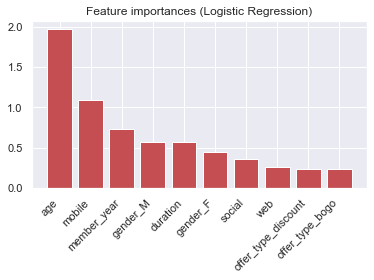

In [398]:
coefs = np.abs(logreg2.coef_[0])
indices = np.argsort(coefs)[::-1]

plt.figure()
plt.title("Feature importances (Logistic Regression)")
plt.bar(range(10), coefs[indices[:10]],
       color="r", align="center")
plt.xticks(range(10), X_train.columns[indices[:10]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

We can notice than the age and the fact that the offer is mobile are important features.
What's more, we can notice discount and bogo are very low in the ranking.
We can not conclude in favor of bogo offer 

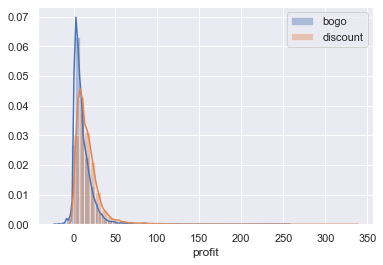

In [399]:
## offer type with profit
sns.distplot(new_kind_offers_summary_suc[new_kind_offers_summary_suc.offer_type=='bogo'].profit,label='bogo')
sns.distplot(new_kind_offers_summary_suc[new_kind_offers_summary_suc.offer_type=='discount'].profit,label='discount')
plt.legend()
plt.show()

We can see on the graph, bogo offers are more likely to allow small profits in comparaison with discount, but the number of profit offers is more important for discount offer.

## Improvements

I managed to get a good understanding of the data. Unfortunately, I was not able to find out which offer was the best. Maybe focus on the different Bogo offers and the different Discount offers to bring out the differences. Also, maybe working on the seasonality of the offers can help to make it clearer.